# CNET 5442 — Sports Analytics Through Data and Networks (Spring 2026)  
## Class 7: Expectation → heatmaps → **logistic regression** (with a simple xG model)

This notebook starts with *expectation* and empirical probabilities (binned heatmaps), then builds a probability model with logistic regression.

We'll use two real datasets (provided with the course repo):
- **NBA 2024** shots (binary make/miss + location)
- **EPL 2024** shots (binary goal/no-goal + location + provided xG)

### Learning goals (too much for 1 class, but hopefully helpful resource)

In this notebook, the goal is to:

0. Use logistic regression on a simple NFL example: model **field goal make probability** from distance, then see how **weather** shifts that curve.
1. Use linearity of expectation to connect shot-by-shot probabilities to totals like expected goals ($\sum p_i$).
2. Build binned heatmaps for shot density and empirical conversion rates, and understand *why bins get noisy*.
3. Explain logistic regression as a model for log-odds and probabilities:
   - what the sigmoid does,
   - why we use log-likelihood / cross-entropy,
   - how to interpret coefficients (odds ratios).
4. Fit and evaluate a simple, interpretable xG model using distance + shot angle, then visualize it on the pitch.
5. (Appendices) Derive gradients, check them numerically, and see Newton/IRLS as a fast optimizer for logistic regression.

In [1]:
# --- Imports and setup ---
import os
from pathlib import Path

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 150)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rc('axes', axisbelow=True)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'


from scipy.ndimage import gaussian_filter
from scipy.stats import beta as beta_dist

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (
    log_loss, roc_auc_score, average_precision_score,
    brier_score_loss, confusion_matrix, classification_report
)
from sklearn.calibration import calibration_curve

# Reproducibility
RNG = np.random.default_rng(7)

try:
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    import statsmodels
    HAS_STATSMODELS = True
except ImportError:
    sm = None
    smf = None
    HAS_STATSMODELS = False


print("Setup complete.")
print("Package versions:")
import sklearn
import matplotlib
print("  numpy:", np.__version__)
print("  pandas:", pd.__version__)
print("  scikit-learn:", sklearn.__version__)
print("  matplotlib:", matplotlib.__version__)
if HAS_STATSMODELS:
    print("  statsmodels:", statsmodels.__version__)
else:
    print("  statsmodels: NOT INSTALLED (optional; used for inference tables)")

Setup complete.
Package versions:
  numpy: 1.22.0
  pandas: 2.0.3
  scikit-learn: 1.0.2
  matplotlib: 3.7.5
  statsmodels: 0.14.1


_____________
## To start: A quick recap of last night's game

Today's hook is football: Super Bowl LX (February 8, 2026) featured a Super Bowl-record **five field goals** by Seattle's kicker Jason Myers. 

We'll use field goals as a quick, clean example of a binary outcome (good vs no good) and fit a distance-based logistic curve. Then we'll return to basketball and soccer shots and build the same ideas into heatmaps and an xG-style model.

![](images/superbowl-logo.png)

Last night's Super Bowl (Super Bowl LX, **February 8, 2026**) was a reminder that not every game is a fireworks show. In a defensive, field-position heavy game, Seattle kicker **Jason Myers made a Super Bowl-record five field goals**.

Field goals are a perfect way to motivate logistic regression because each attempt has a clean binary outcome:

- **good** (3 points) vs **no good / blocked** (0 points)

If you are a coach choosing between “go for it” and “kick,” you are implicitly asking a probability question:

> Given the kick distance (and conditions like wind, rain, and temperature), what is the probability this field goal is good?

That is exactly the kind of question logistic regression is built for. So we'll start with a short excursion into NFL field goal data, then reuse the same probability modeling ideas for shot charts and xG later in the notebook.

___________

### Data sources and files for this warm-up

We'll work with play-by-play field goal attempts and a matched weather archive. To keep the focus on modeling (not scraping), the relevant data have already been exported into three CSVs:


- `field_goal_attempts.csv`: one row per field goal attempt, parsed from play-by-play descriptions (distance, time, make/miss).
- `nfl_weather.csv`: hourly weather observations keyed by NFL `game_id` (temperature, wind, precipitation, etc.).
- `fg_wx.csv`: the merged dataset that attaches the *nearest hourly* weather record to each kick.


The play-by-play data come from **NFL Savant** and are compiled from publicly available NFL play-by-play feeds. The weather archive is compiled by **Tom Bliss** (DataWithBliss) and documents how game IDs are matched to Meteostat-based weather observations.

References:
- NFL Savant “About” page: https://nflsavant.com/about.php  
- Tom Bliss, “NFL Weather Data”: https://www.datawithbliss.com/weather-data

**A note on time alignment.** Weather is reported hourly, while play-by-play is in *game clock* (quarter, minute, second). In `fg_wx.csv`, we map game clock to an approximate wall-clock time within each game, then match each kick to the nearest hourly weather observation. That’s enough to learn something real about weather effects, but it is not "weather at the exact second of the kick."

In [2]:
df_fg = pd.read_csv('data/field_goal_attempts.csv')
wx = pd.read_csv('data/nfl_weather.csv')
fg_wx = pd.read_csv('data/fg_wx.csv')

df_fg.head()

,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,LengthFG,Description,PlayType,Outcome,OutcomePts,FieldGoalMade
0,2013122913,2013-12-29,2,12,42,DEN,LV,4,10,84,34,"(12:42) 5-M.PRATER 34 YARD FIELD GOAL IS GOOD,...",FIELD GOAL,IS GOOD,3,1
1,2013122213,2013-12-22,4,6,28,SD,LV,4,4,85,33,"(6:28) 9-N.NOVAK 33 YARD FIELD GOAL IS GOOD, C...",FIELD GOAL,IS GOOD,3,1
2,2013122213,2013-12-22,4,14,55,SD,LV,4,7,90,28,"(14:55) 9-N.NOVAK 28 YARD FIELD GOAL IS GOOD, ...",FIELD GOAL,IS GOOD,3,1
3,2013122213,2013-12-22,3,1,0,SD,LV,4,3,70,48,"(1:00) 9-N.NOVAK 48 YARD FIELD GOAL IS GOOD, C...",FIELD GOAL,IS GOOD,3,1
4,2013122213,2013-12-22,1,2,45,SD,LV,4,8,91,27,"(2:45) 9-N.NOVAK 27 YARD FIELD GOAL IS GOOD, C...",FIELD GOAL,IS GOOD,3,1


### First look: distance vs make/miss

A raw scatter plot of *make* (1) / *miss* (0) against kick distance is noisy (because outcomes are binary), but the pattern is obvious: longer kicks are made less often.

The goal of logistic regression in this warm-up is to replace that noisy cloud with a smooth estimate of $P(\text{make} \mid \text{distance})$.


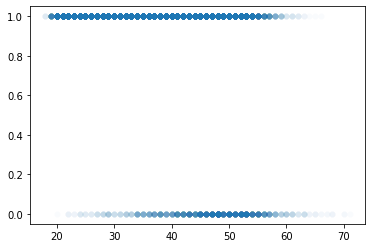

In [3]:
plt.scatter(df_fg['LengthFG'].values,df_fg['FieldGoalMade'].values, alpha=0.025, lw=0);

### Distance-only logistic regression

We'll fit a one-feature model:

$$
P(\text{make}\mid x) = \sigma(\beta_0 + \beta_1 x),
$$

where $x$ is the kick distance (yards) and $\sigma(\cdot)$ is the logistic sigmoid. Don’t worry about the math yet—we’ll do it carefully in Part 2. For now, notice the basic behavior: a monotone, S-shaped curve that stays between 0 and 1.

In [4]:
# --- logistic fit: FieldGoalMade ~ LengthFG ---
x = df_fg['LengthFG'].astype(float).values
y = df_fg['FieldGoalMade'].astype(int).values

In [5]:
# --- logistic fit: FieldGoalMade ~ LengthFG ---
x = df_fg['LengthFG'].astype(float).values
y = df_fg['FieldGoalMade'].astype(int).values

X = sm.add_constant(x)  # adds intercept term
model = sm.Logit(y, X)
res = model.fit(disp=False)

beta0, beta1 = res.params

In [6]:
print(res.summary())
print(f"\nFitted curve: p(make|x) = 1/(1 + exp(-({beta0:.4f} + {beta1:.4f} x)))")

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                11949
Model:                          Logit   Df Residuals:                    11947
Method:                           MLE   Df Model:                            1
Date:                Mon, 09 Feb 2026   Pseudo R-squ.:                  0.1424
Time:                        14:23:38   Log-Likelihood:                -4448.3
converged:                       True   LL-Null:                       -5187.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1527      0.144     42.600      0.000       5.870       6.436
x1            -0.1062      0.003    -33.738      0.000      -0.112      -0.100

Fitted curve: p(make|x) = 1/(1 + exp(-(6.1527 + -0.

### Interpreting the logistic regression output (line by line)

This table is the standard `statsmodels` summary for a **logistic regression (Logit)** model. In this model, the outcome is binary (made vs missed), and the predictor is field-goal distance $x$.

---


#### Model form (what was fit)

The model assumes that the **log-odds** of making a field goal is linear in distance (more on this below!):

$$
\log\left(\frac{p}{1-p}\right) = \beta_0 + \beta_1 x
$$

where:

- $p = \Pr(\text{make} \mid x)$ is the probability the kick is good,
- $\beta_0$ is the intercept,
- $\beta_1$ is the coefficient multiplying distance $x$.


Equivalently, the fitted probability curve is:

$$
p(\text{make}\mid x) = \frac{1}{1+\exp\left(-(\beta_0 + \beta_1 x)\right)}.
$$

Your fitted coefficients are:

- $\hat\beta_0 = 6.1527$
- $\hat\beta_1 = -0.1062$

so

$$
p(\text{make}\mid x) = \frac{1}{1+\exp\left(-(6.1527 - 0.1062\,x)\right)}.
$$

---

### Top panel: what each line means

**Dep. Variable: y**  
The dependent variable is called `y`. In your use case, this is the binary indicator (e.g., `FieldGoalMade`), where typically:
- $y=1$ means the field goal was made
- $y=0$ means it was missed/blocked


**No. Observations: 11949**  
There are 11,949 field-goal attempts included in this fit (after any filtering / dropping missing values).


**Model: Logit**  
This is a logistic regression model (Bernoulli GLM with a logit link), fit by maximum likelihood.


**Df Residuals: 11947**  
Degrees of freedom for residuals is $n - k$, where:
- $n = 11949$ observations,
- $k = 2$ estimated parameters here (intercept + one slope).
So $11949 - 2 = 11947$.


**Method: MLE**  
The coefficients were estimated by **maximum likelihood estimation**, i.e., choosing $\beta_0,\beta_1$ to maximize the Bernoulli likelihood.


**Df Model: 1**  
There is 1 predictor variable in the model (distance). The intercept does not count toward `Df Model`.


**Date / Time**  
Just when the model summary was produced.


**Pseudo R-squ.: 0.1424**  
This is McFadden’s pseudo-$R^2$:

$$
R^2_{\text{McF}} = 1 - \frac{\ell(\hat\beta)}{\ell(\beta_{\text{null}})}
$$

where $\ell(\hat\beta)$ is the log-likelihood of the fitted model and $\ell(\beta_{\text{null}})$ is the log-likelihood of the intercept-only model.  
A value of 0.1424 means the fitted model improves log-likelihood meaningfully over the null model, but it is not interpreted the same way as linear-regression $R^2$.


**Log-Likelihood: -4448.3**  
This is $\ell(\hat\beta)$, the log-likelihood at the fitted coefficients. Less negative is better.


**converged: True**  
The numerical optimization succeeded (the MLE routine converged).


**LL-Null: -5187.1**  
This is the log-likelihood of the **null model** (intercept-only, no distance term). The fact that this is much smaller (more negative) than -4448.3 indicates distance is informative.


**Covariance Type: nonrobust**  
Standard errors were computed using the usual model-based (non-robust) covariance estimator, not heteroskedasticity-robust or clustered SEs.


**LLR p-value: 0.000**  
This is the p-value from the **likelihood ratio test** comparing:
- null model (intercept-only)
vs
- your fitted model (intercept + distance)

A value reported as 0.000 means “extremely small” (often $<10^{-3}$). It indicates the model with distance fits significantly better than the null model.

---

### Coefficient table: what each column means

The coefficient table lists each estimated parameter and its uncertainty.


#### Rows
**const**  
This is the intercept $\beta_0$.

**x1**  
This is the slope $\beta_1$ for the predictor `x1` (your distance variable $x$).



#### Columns
**coef**  
The estimated coefficient value.

- `const = 6.1527` means $\hat\beta_0 = 6.1527$.
- `x1 = -0.1062` means $\hat\beta_1 = -0.1062$.

Interpreting the sign: because $\hat\beta_1 < 0$, increasing distance lowers the log-odds (and therefore lowers the probability) of making the kick.


**std err**  
The standard error of the coefficient estimate, i.e., the estimated standard deviation of $\hat\beta$ across hypothetical repeated samples.

- SE($\hat\beta_0$) = 0.144  
- SE($\hat\beta_1$) = 0.003

Smaller SE means more precise estimates.


**z**  
The Wald z-statistic testing $H_0:\beta=0$:

$$
z = \frac{\hat\beta}{\text{SE}(\hat\beta)}.
$$

- For `x1`, $z=-33.738$ is very large in magnitude, indicating strong evidence that the slope is not zero.

**P>|z|**  
The two-sided p-value for the Wald test of $H_0:\beta=0$.

- Both p-values are shown as 0.000 (i.e., extremely small), meaning the intercept and slope are statistically different from 0.

**[0.025, 0.975]**  
The 95% confidence interval for each coefficient (Wald CI):

$$
\hat\beta \pm 1.96\cdot \text{SE}(\hat\beta).
$$

- Intercept CI: $[5.870,\ 6.436]$
- Slope CI: $[-0.112,\ -0.100]$

Because the slope CI is entirely negative, it supports the conclusion that longer kicks reduce make probability.


---

### Interpreting the slope in more intuitive terms (odds ratio)

In a logistic model, a 1-yard increase changes the **odds** by a multiplicative factor:

$$
\text{OR}_{1\ \text{yard}} = e^{\beta_1}.
$$

Here:

$$
e^{-0.1062} \approx 0.899,
$$

so each additional yard multiplies the odds of making the kick by about 0.899 (roughly a **10% decrease in odds per yard**, holding everything else fixed).


---

### Your fitted curve (as printed)

The model printed:

> Fitted curve: p(make|x) = 1/(1 + exp(-(6.1527 + -0.1062 x)))

which is the same as:

$$
p(\text{make}\mid x) = \frac{1}{1+\exp\left(-(6.1527 - 0.1062\,x)\right)}.
$$

In [7]:
print(res.summary())
print(f"\nFitted curve: p(make|x) = 1/(1 + exp(-({beta0:.4f} + {beta1:.4f} x)))")

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                11949
Model:                          Logit   Df Residuals:                    11947
Method:                           MLE   Df Model:                            1
Date:                Mon, 09 Feb 2026   Pseudo R-squ.:                  0.1424
Time:                        14:23:38   Log-Likelihood:                -4448.3
converged:                       True   LL-Null:                       -5187.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1527      0.144     42.600      0.000       5.870       6.436
x1            -0.1062      0.003    -33.738      0.000      -0.112      -0.100

Fitted curve: p(make|x) = 1/(1 + exp(-(6.1527 + -0.

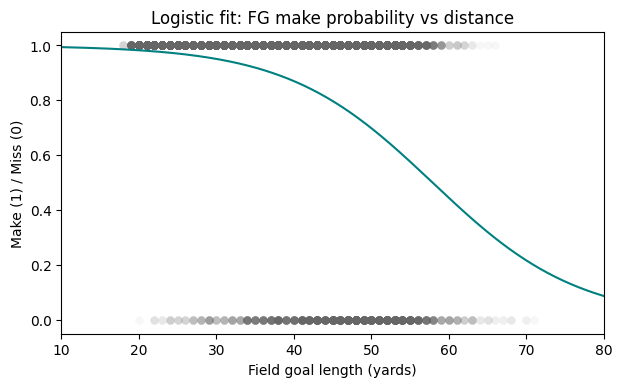

In [8]:
# --- plot: scatter + fitted logistic curve ---
xgrid = np.linspace(10, 90, 400)
# xgrid = np.linspace(x.min(), x.max(), 400)
pgrid = 1.0 / (1.0 + np.exp(-(beta0 + beta1 * xgrid)))

fig, ax = plt.subplots(1,1,figsize=(7,4),dpi=100)

ax.scatter(x, y, alpha=0.05, color='.4', lw=0)
ax.plot(xgrid, pgrid, color='teal')
ax.set_ylim(-0.05, 1.05)
ax.set_xlim(10, 80)
ax.set_xlabel("Field goal length (yards)")
ax.set_ylabel("Make (1) / Miss (0)")
ax.set_title("Logistic fit: FG make probability vs distance")


plt.show()

_________
### Adding weather: does the curve shift?

Distance is not the whole story. Wind, precipitation, and temperature plausibly change both the *physics* (ball flight) and the *strategy* (which kicks are attempted). If we can attach weather conditions to each kick, we can ask a slightly richer question:

> Holding distance fixed, do certain conditions make a field goal more or less likely?

Below, `fg_wx.csv` is the pre-merged “kicks + nearest hourly weather” dataset. The next few cells show one transparent way to construct it from `field_goal_attempts.csv` and `nfl_weather.csv` (you can skim on a first pass).


In [9]:
fg_wx = pd.read_csv('data/fg_wx.csv')

In [10]:
fg_wx.head()

,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,LengthFG,Description,PlayType,Outcome,OutcomePts,FieldGoalMade,game_id,qtr_remaining_sec,elapsed_sec,kickoff_dt,kick_dt,game_id_wx,Source,DistanceToStation,TimeMeasure,Temperature,DewPoint,Humidity,Precipitation,WindSpeed,WindDirection,Pressure,EstimatedCondition
0,2013090800,2013-09-08,1,4,51,NE,BUF,4,11,70,48,(4:51) 3-S.GOSTKOWSKI 48 YARD FIELD GOAL IS GO...,FIELD GOAL,IS GOOD,3,1,2013090800,291,609,2013-09-08 13:00:00,2013-09-08 13:10:09,2013090800,Meteostat,7.02,2013-09-08 13:00:00,64.94,46.94,52.0,0.0,11.43,20.0,30.0733,Clear
1,2013090800,2013-09-08,4,10,52,NE,BUF,4,15,85,33,(10:52) 3-S.GOSTKOWSKI 33 YARD FIELD GOAL IS G...,FIELD GOAL,IS GOOD,3,1,2013090800,652,2948,2013-09-08 13:00:00,2013-09-08 13:49:08,2013090800,Meteostat,7.02,2013-09-08 14:00:00,64.94,46.94,52.0,0.0,6.96,10.0,30.0733,Clear
2,2013090800,2013-09-08,4,0,9,NE,BUF,3,13,83,35,(:09) 3-S.GOSTKOWSKI 35 YARD FIELD GOAL IS GOO...,FIELD GOAL,IS GOOD,3,1,2013090800,9,3591,2013-09-08 13:00:00,2013-09-08 13:59:51,2013090800,Meteostat,7.02,2013-09-08 14:00:00,64.94,46.94,52.0,0.0,6.96,10.0,30.0733,Clear
3,2013090801,2013-09-08,2,9,40,SEA,CAR,4,8,91,27,(9:40) 4-S.HAUSCHKA 27 YARD FIELD GOAL IS GOOD...,FIELD GOAL,IS GOOD,3,1,2013090801,580,1220,2013-09-08 13:00:00,2013-09-08 13:20:20,2013090801,Meteostat,8.57,2013-09-08 13:00:00,86.00,60.98,43.0,0.0,8.08,0.0,29.9759,Clear
4,2013090801,2013-09-08,3,2,26,SEA,CAR,4,15,78,40,(2:26) 4-S.HAUSCHKA 40 YARD FIELD GOAL IS GOOD...,FIELD GOAL,IS GOOD,3,1,2013090801,146,2554,2013-09-08 13:00:00,2013-09-08 13:42:34,2013090801,Meteostat,8.57,2013-09-08 14:00:00,84.20,60.62,45.0,0.0,8.08,0.0,29.9641,Clear


### Logistic regression with weather covariates

Now we fit a logistic regression where the outcome is `FieldGoalMade` and the predictors include:

- kick distance (`LengthFG`)
- weather features (temperature, wind speed, and precipitation when available)

Two things to look for:

1. **Direction and magnitude** of the weather coefficients (especially wind).
2. Whether adding weather actually improves fit in a meaningful way (not just “a p-value is small”).

We standardize continuous predictors (so coefficients correspond to a one-standard-deviation change) and report **odds ratios** to keep interpretation concrete.


In [11]:
df = pd.read_csv("data/fg_wx.csv")

# Required
ycol = "FieldGoalMade"
xcol = "LengthFG"

# Weather (optional, will use what exists)
temp_col   = "Temperature"
wind_col   = "WindSpeed"
precip_col = "Precipitation"

In [12]:
# ----------------------------
# Clean + engineer features
# ----------------------------
d = df.copy()

# Outcome and distance
d[ycol] = pd.to_numeric(d[ycol], errors="coerce")
d[xcol] = pd.to_numeric(d[xcol], errors="coerce")

In [13]:
# Weather numerics
for c in [temp_col, wind_col, precip_col]:
    if c is not None:
        d[c] = pd.to_numeric(d[c], errors="coerce")

In [14]:
# Indoor indicator (best-effort)
d["is_indoor"] = np.nan

In [15]:
# Precip indicator
if precip_col is not None:
    d["any_precip"] = (d[precip_col].fillna(0) > 0).astype(int)
else:
    d["any_precip"] = np.nan

In [16]:
# Keep only relevant columns and drop missing outcome/distance
keep = [ycol, xcol]
for c in [temp_col, wind_col, precip_col, "any_precip", "is_indoor"]:
    if c is not None and c in d.columns:
        keep.append(c)

d_model = d[keep].dropna(subset=[ycol, xcol]).copy()

In [17]:
# ----------------------------
# Decide which weather terms to include
# ----------------------------
weather_terms = []
if temp_col is not None:
    weather_terms.append(temp_col)
if wind_col is not None:
    weather_terms.append(wind_col)

In [18]:
# choose ONE precip representation: raw precip if mostly present, else binary any_precip
use_raw_precip = precip_col is not None and d_model[precip_col].notna().mean() > 0.2
if use_raw_precip:
    weather_terms.append(precip_col)
else:
    if d_model["any_precip"].notna().mean() > 0.2:
        weather_terms.append("any_precip")

# include indoor if it has enough coverage
if d_model["is_indoor"].notna().mean() > 0.2:
    weather_terms.append("is_indoor")

In [19]:
# If we're including weather, drop rows missing those fields
if weather_terms:
    d_model = d_model.dropna(subset=weather_terms).copy()

print("Using columns:")
print("  y:", ycol)
print("  x:", xcol)
print("  weather:", weather_terms if weather_terms else "(none found)")

Using columns:
  y: FieldGoalMade
  x: LengthFG
  weather: ['Temperature', 'WindSpeed', 'Precipitation']


In [20]:
# ----------------------------
# Standardize continuous predictors
# ----------------------------
cont = [xcol]
for c in weather_terms:
    if c in ["any_precip", "is_indoor"]:
        continue
    cont.append(c)

standardize_params = {}
for c in cont:
    mu = d_model[c].mean()
    sd = d_model[c].std()
    if not np.isfinite(sd) or sd == 0:
        sd = 1.0
    d_model[c + "_z"] = (d_model[c] - mu) / sd
    standardize_params[c] = (mu, sd)

x_z = xcol + "_z"
w_z = []
for c in weather_terms:
    if c in ["any_precip", "is_indoor"]:
        w_z.append(c)
    else:
        w_z.append(c + "_z")

In [21]:
# ----------------------------
# Fit baseline and expanded logistic models
# ----------------------------
y = d_model[ycol].astype(int).values

# Baseline: distance only
X0 = sm.add_constant(d_model[[x_z]].values)
m0 = sm.Logit(y, X0).fit(disp=False)

m1 = None
if w_z:
    X1 = sm.add_constant(d_model[[x_z] + w_z].values)
    m1 = sm.Logit(y, X1).fit(disp=False)

In [22]:
print("\n=== Baseline (distance only) ===")
print(m0.summary())


=== Baseline (distance only) ===
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5373
Model:                          Logit   Df Residuals:                     5371
Method:                           MLE   Df Model:                            1
Date:                Mon, 09 Feb 2026   Pseudo R-squ.:                  0.1500
Time:                        14:23:38   Log-Likelihood:                -2041.9
converged:                       True   LL-Null:                       -2402.3
Covariance Type:            nonrobust   LLR p-value:                9.649e-159
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0219      0.050     40.153      0.000       1.923       2.121
x1            -1.1440      0.049    -23.295      0.000      -1.240      -1.048


In [23]:
print("\n=== Expanded (distance + weather) ===")
print(m1.summary())


=== Expanded (distance + weather) ===
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5373
Model:                          Logit   Df Residuals:                     5368
Method:                           MLE   Df Model:                            4
Date:                Mon, 09 Feb 2026   Pseudo R-squ.:                  0.1521
Time:                        14:23:38   Log-Likelihood:                -2036.8
converged:                       True   LL-Null:                       -2402.3
Covariance Type:            nonrobust   LLR p-value:                7.111e-157
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0270      0.051     40.133      0.000       1.928       2.126
x1            -1.1482      0.049    -23.314      0.000      -1.245      -1.052
x2           

In [24]:
# ----------------------------
# Odds ratios + 95% CI (ROBUST)
# ----------------------------
param_names = ["const", x_z] + w_z

params = pd.Series(m1.params, index=param_names)

conf_raw = m1.conf_int()
if isinstance(conf_raw, pd.DataFrame):
    conf = conf_raw.copy()
    conf.index = param_names
    if conf.shape[1] == 2:
        conf.columns = ["low", "high"]
else:
    conf = pd.DataFrame(conf_raw, columns=["low", "high"], index=param_names)

or_tbl = pd.DataFrame({
    "OR": np.exp(params),
    "OR_low": np.exp(conf["low"]),
    "OR_high": np.exp(conf["high"]),
})

print("\nOdds ratios (per 1 SD for *_z, per 1 unit for binaries):")
print(or_tbl)


Odds ratios (per 1 SD for *_z, per 1 unit for binaries):
                       OR    OR_low   OR_high
const            7.591401  6.875908  8.381347
LengthFG_z       0.317201  0.288013  0.349347
Temperature_z    1.017656  0.940668  1.100945
WindSpeed_z      0.904690  0.837850  0.976862
Precipitation_z  0.942264  0.877801  1.011461


In [25]:
# ----------------------------
# Plot: predicted make prob vs distance under weather scenarios
# ----------------------------
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# distance grid in raw units
x_raw = np.linspace(d_model[xcol].min(), d_model[xcol].max(), 250)
x_mu, x_sd = standardize_params[xcol]
x_grid_z = (x_raw - x_mu) / x_sd

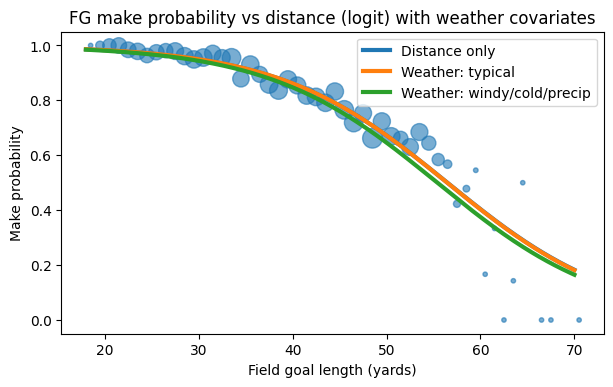

In [26]:
plt.figure(figsize=(7, 4),dpi=100)

# binned empirical rates
bins = np.arange(int(d_model[xcol].min()), int(d_model[xcol].max()) + 2)
tmp = pd.DataFrame({"x": d_model[xcol].values, "y": y})
tmp["bin"] = pd.cut(tmp["x"], bins=bins, right=False)
bs = tmp.groupby("bin", observed=True).agg(n=("y", "size"), rate=("y", "mean"))
bc = np.array([iv.left for iv in bs.index]) + 0.5
plt.scatter(bc, bs["rate"].values, s=np.clip(bs["n"].values, 10, 200), alpha=0.6)

# baseline curve
z0 = m0.params[0] + m0.params[1] * x_grid_z
plt.plot(x_raw, sigmoid(z0), linewidth=3, label="Distance only")

# scenario vectors in z/binary space
# "typical": mean weather => 0 in z-space; binaries 0
typical = {k: 0.0 for k in w_z}

# "bad": windy (+1 SD), colder (-1 SD), precip=1 if binary, indoor=0
bad = {k: 0.0 for k in w_z}
for k in w_z:
    lk = k.lower()
    if "wind" in lk:
        bad[k] = 1.0
    if "temp" in lk or "temperature" in lk:
        bad[k] = -1.0
    if k == "any_precip":
        bad[k] = 1.0
    if k == "is_indoor":
        bad[k] = 0.0

# compute curves
p = m1.params

z_typ = p[0] + p[1] * x_grid_z
for j, k in enumerate(w_z, start=2):
    z_typ += p[j] * typical[k]
plt.plot(x_raw, sigmoid(z_typ), linewidth=3, label="Weather: typical")

z_bad = p[0] + p[1] * x_grid_z
for j, k in enumerate(w_z, start=2):
    z_bad += p[j] * bad[k]
plt.plot(x_raw, sigmoid(z_bad), linewidth=3, label="Weather: windy/cold/precip")

plt.ylim(-0.05, 1.05)
plt.xlabel("Field goal length (yards)")
plt.ylabel("Make probability")
plt.title("FG make probability vs distance (logit) with weather covariates")
plt.legend()

plt.savefig('images/pngs/weather_fieldgoal.png',dpi=425,bbox_inches='tight')
plt.savefig('images/pdfs/weather_fieldgoal.pdf',dpi=425,bbox_inches='tight')
plt.show()

_____________
## From kicks to shots

The field goal example is intentionally small: one primary feature (distance), a few contextual covariates (weather), and a clean binary outcome. But the structure is the same in the rest of the notebook:

- In **basketball**, we’ll estimate $P(\text{make} \mid \text{location})$ and turn it into **expected points**.
- In **soccer**, we’ll estimate $P(\text{goal} \mid \text{location})$ and connect it to **expected goals (xG)**.

Next, we zoom out to *many* events and ask how probabilities add up (linearity of expectation), why empirical heatmaps get noisy, and how logistic regression gives us a smoother probability model.


## Part 0 — Helper functions

We'll define:
- **robust file loading** (so the notebook works in different folder layouts),
- **2D binning** (shot heatmaps),
- safe conversion-rate computations (avoid division-by-zero),
- **field/court drawing** that matches the *actual coordinates* in our CSVs,
- feature functions (distance + angle) used by the xG logistic regression model.



In [27]:
def find_file(candidates):
    """Return the first existing path from a list of candidate relative paths."""
    for c in candidates:
        p = Path(c)
        if p.exists():
            return p
    return None

def read_csv_safely(candidates, **kwargs):
    """Try a list of candidate paths; raise a helpful error if none exist."""
    p = find_file(candidates)
    if p is None:
        raise FileNotFoundError(
            "Could not find the file. Tried:\n- " + "\n- ".join(map(str, candidates))
        )
    df = pd.read_csv(p, **kwargs)
    return df, p

def heatmap2d(x, y, bins=(50, 50), range_=None, weights=None, smooth_sigma=None):
    """2D histogram (optionally weighted) with optional Gaussian smoothing.

    Returns (H, xedges, yedges) where H is transposed so it can be passed directly to imshow().
    """
    H, xedges, yedges = np.histogram2d(x, y, bins=bins, range=range_, weights=weights)
    if smooth_sigma is not None:
        H = gaussian_filter(H, sigma=smooth_sigma)
    return H.T, xedges, yedges

def safe_rate(numer, denom, min_denom=10):
    """Compute numer/denom with NaNs where denom is too small."""
    numer = np.asarray(numer, dtype=float)
    denom = np.asarray(denom, dtype=float)
    out = np.full_like(numer, np.nan, dtype=float)
    mask = denom >= min_denom
    out[mask] = numer[mask] / denom[mask]
    return out

# -----------------------------
# Soccer: Understat-style coords
# -----------------------------
SOCCER_LENGTH_M = 105.0
SOCCER_WIDTH_M  = 68.0
GOAL_WIDTH_M    = 7.32

def understat_to_meters(X, Y, length=SOCCER_LENGTH_M, width=SOCCER_WIDTH_M):
    """Understat uses X,Y in [0,1]. Convert to meters on a (length x width) pitch."""
    return X * length, Y * width

def draw_soccer_pitch(ax, color='black', lw=1.5, length=SOCCER_LENGTH_M, width=SOCCER_WIDTH_M):
    """Simple pitch (meters) with goals on x=0 and x=length."""
    ax.add_patch(patches.Rectangle((0,0), length, width, fill=False, ec=color, lw=lw))
    ax.plot([length/2, length/2],[0,width], color=color, lw=lw)
    ax.add_patch(patches.Circle((length/2,width/2), 9.15, fill=False, ec=color, lw=lw))
    # Penalty boxes
    ax.add_patch(patches.Rectangle((0, (width-40.32)/2), 16.5, 40.32, fill=False, ec=color, lw=lw))
    ax.add_patch(patches.Rectangle((length-16.5, (width-40.32)/2), 16.5, 40.32, fill=False, ec=color, lw=lw))
    # 6-yard boxes
    ax.add_patch(patches.Rectangle((0, (width-18.32)/2), 5.5, 18.32, fill=False, ec=color, lw=lw))
    ax.add_patch(patches.Rectangle((length-5.5, (width-18.32)/2), 5.5, 18.32, fill=False, ec=color, lw=lw))
    # Goals (simple rectangles outside the pitch)
    ax.add_patch(patches.Rectangle((-2, (width-GOAL_WIDTH_M)/2), 2, GOAL_WIDTH_M, fill=False, ec=color, lw=lw))
    ax.add_patch(patches.Rectangle((length, (width-GOAL_WIDTH_M)/2), 2, GOAL_WIDTH_M, fill=False, ec=color, lw=lw))
    ax.set_xlim(-2,length+2); ax.set_ylim(-2,width+2)
    ax.set_aspect('equal'); ax.axis('off')

def soccer_distance_angle(x_m, y_m, goal_x=SOCCER_LENGTH_M, goal_y=SOCCER_WIDTH_M/2, goal_width=GOAL_WIDTH_M):
    """Distance and open angle to goal (between lines to the two posts)."""
    dx = goal_x - x_m
    dist = np.sqrt(dx*dx + (y_m-goal_y)**2)

    post1_y = goal_y - goal_width/2
    post2_y = goal_y + goal_width/2
    ang1 = np.arctan2(post1_y - y_m, goal_x - x_m)
    ang2 = np.arctan2(post2_y - y_m, goal_x - x_m)
    angle = np.abs(ang2 - ang1)  # radians in [0, pi]
    return dist, angle

# ------------------------------------
# Basketball: feet, baseline-centered
# ------------------------------------
COURT_LENGTH_FT = 94.0
COURT_WIDTH_FT  = 50.0
HOOP_Y_FT       = 5.25  # NBA hoop center is 5.25 ft from baseline

def draw_nba_court(ax, color='black', lw=1.5, full=False):
    """NBA court in *feet* with origin at center of near baseline (x=0, y=0).

    Our shot data uses:
      - LOC_X in [-25, 25] (feet, left/right from center)
      - LOC_Y in [0, 94] (feet, from near baseline toward far baseline)
    """
    length = COURT_LENGTH_FT if full else COURT_LENGTH_FT/2
    # Outer lines
    ax.add_patch(patches.Rectangle((-COURT_WIDTH_FT/2, 0), COURT_WIDTH_FT, length, fill=False, ec=color, lw=lw))
    # Hoop + backboard
    ax.add_patch(patches.Circle((0, HOOP_Y_FT), 0.75, fill=False, ec=color, lw=lw))
    ax.plot([-3, 3], [4, 4], color=color, lw=lw)  # backboard
    # Paint (lane)
    ax.add_patch(patches.Rectangle((-8, 0), 16, 19, fill=False, ec=color, lw=lw))
    # Free-throw circle
    ax.add_patch(patches.Circle((0, 19), 6, fill=False, ec=color, lw=lw))
    # Restricted area arc
    ax.add_patch(patches.Arc((0, HOOP_Y_FT), 8, 8, theta1=0, theta2=180, ec=color, lw=lw))
    # Three-point lines (approx NBA)
    ax.plot([-22, -22], [0, 14], color=color, lw=lw)
    ax.plot([ 22,  22], [0, 14], color=color, lw=lw)
    # Three-point arc: radius 23.75 ft from hoop center
    corner_angle = np.degrees(np.arctan2(14 - HOOP_Y_FT, 22))  # about 21.7 deg
    ax.add_patch(patches.Arc((0, HOOP_Y_FT), 47.5, 47.5,
                             theta1=corner_angle, theta2=180-corner_angle,
                             ec=color, lw=lw))
    if full:
        # Far hoop (purely for drawing context)
        far_hoop_y = COURT_LENGTH_FT - HOOP_Y_FT
        ax.add_patch(patches.Circle((0, far_hoop_y), 0.75, fill=False, ec=color, lw=lw))
        ax.plot([-3, 3], [COURT_LENGTH_FT-4, COURT_LENGTH_FT-4], color=color, lw=lw)
        # Half-court line
        ax.plot([-COURT_WIDTH_FT/2, COURT_WIDTH_FT/2], [COURT_LENGTH_FT/2, COURT_LENGTH_FT/2], color=color, lw=lw)
        ax.add_patch(patches.Circle((0, COURT_LENGTH_FT/2), 6, fill=False, ec=color, lw=lw))
    ax.set_xlim(-COURT_WIDTH_FT/2, COURT_WIDTH_FT/2)
    ax.set_ylim(0, length)
    ax.set_aspect('equal'); ax.axis('off')

def bball_distance_angle(x_ft, y_ft, hoop_x=0.0, hoop_y=HOOP_Y_FT):
    """Distance and angle-to-hoop (polar angle) in feet.

    Angle here is just the polar angle relative to the hoop center:
      angle = arctan2(|x|, y - hoop_y)  (0 = straight on; larger = more lateral)
    """
    dx = x_ft - hoop_x
    dy = y_ft - hoop_y
    dist = np.sqrt(dx*dx + dy*dy)
    angle = np.arctan2(np.abs(dx), np.maximum(dy, 1e-9))
    return dist, angle

print("Helpers loaded.")

Helpers loaded.


### Quick coordinate sanity checks

Before we do any modeling, we confirm what the coordinates *mean*.

- **Soccer (EPL 2024 shots)**: `X` and `Y` are in $[0,1]$ (Understat-style). We convert to meters on a $105\times 68$ pitch.
- **Basketball (NBA 2024 shots)**: `LOC_X` and `LOC_Y` are in **feet** with
  - `LOC_X` in $[-25,25]$ (left/right from center),
  - `LOC_Y` in $[0,94]$ (from the near baseline toward the far baseline).

In [28]:
# --- Load the datasets (robust paths) ---
nba = pd.read_csv("data/bball/NBA_2024_Shots.csv")

soc = pd.read_csv("data/soccer/EPL_2024_shots.csv")

print("Loaded:")
print(f"  NBA shots: {nba.shape}")
print(f"  EPL shots: {soc.shape}")

# Coordinate checks
print("\nNBA LOC_X range:", (nba['LOC_X'].min(), nba['LOC_X'].max()))
print("NBA LOC_Y range:", (nba['LOC_Y'].min(), nba['LOC_Y'].max()))
print("EPL X,Y range:", (soc['X'].min(), soc['X'].max()), (soc['Y'].min(), soc['Y'].max()))


Loaded:
  NBA shots: (218701, 26)
  EPL shots: (9878, 22)

NBA LOC_X range: (-25.0, 25.0)
NBA LOC_Y range: (0.0500000000000002, 89.35000000000001)
EPL X,Y range: (0.0060000002384185, 0.9940000152587892) (0.0559999990463256, 0.995)


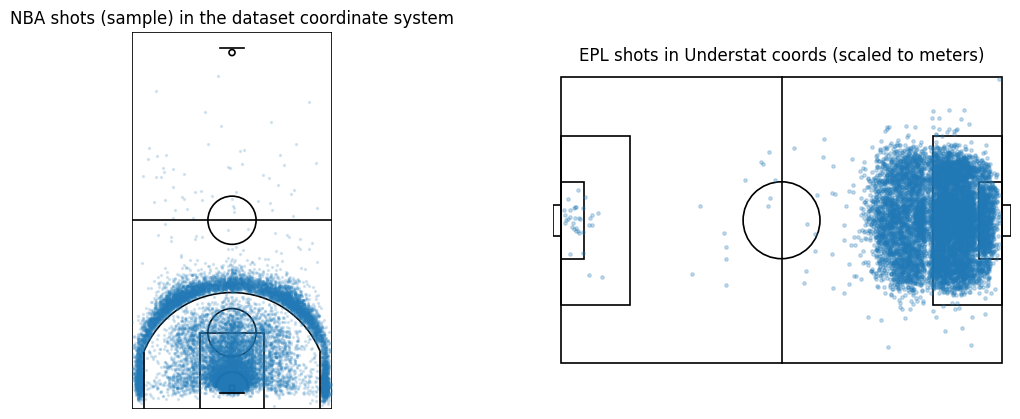

In [29]:
# Visual: do shots land where we expect?

fig, axes = plt.subplots(1, 2, figsize=(13, 5), dpi=100)

# Basketball (sample to avoid plotting 200k points)
ax = axes[0]
draw_nba_court(ax, color="black", lw=1.2, full=True)
sample = nba.sample(n=min(len(nba), 25000), random_state=7)
ax.scatter(sample["LOC_X"], sample["LOC_Y"], s=2, alpha=0.15)
ax.set_title("NBA shots (sample) in the dataset coordinate system")

# Soccer
ax = axes[1]
draw_soccer_pitch(ax, color="black", lw=1.2)
x_m, y_m = understat_to_meters(soc["X"].to_numpy(), soc["Y"].to_numpy())
ax.scatter(x_m, y_m, s=6, alpha=0.25)
ax.set_title("EPL shots in Understat coords (scaled to meters)")

plt.show()


# Part 1 — Expectation → empirical probabilities → heatmaps

The key idea is **linearity of expectation**:

If shot $i$ has probability of success $p_i$, then the expected number of successes is

$$
\mathbb{E}\left[\sum_{i=1}^n Y_i\right] = \sum_{i=1}^n \mathbb{E}[Y_i] = \sum_{i=1}^n p_i,
$$

where each $Y_i \sim \text{Bernoulli}(p_i)$ is an indicator (1 = success, 0 = failure).

In sports:
- In soccer, "success" might mean **goal**, so $\sum p_i$ is **expected goals**.
- In basketball, "success" might mean **made shot**, so $\sum p_i$ is **expected makes**.
- If you multiply by shot value (2 or 3), you get **expected points**.

Before modeling $p_i$ smoothly, we'll estimate it empirically with **bins** (heatmaps).


## 1.1 Bernoulli expectation, variance, and "why bins get noisy"

Suppose $Y \sim \text{Bernoulli}(p)$, i.e. $P(Y=1)=p$ and $P(Y=0)=1-p$.

Then:
- $\mathbb{E}[Y] = p$
- $\text{Var}(Y) = p(1-p)$

If we take $n$ independent shots with the same success probability $p$ and compute the sample mean

$$
\hat p = \frac{1}{n}\sum_{i=1}^n Y_i,
$$

then:
- $\mathbb{E}[\hat p] = p$ (unbiased)
- $\text{Var}(\hat p) = \frac{p(1-p)}{n}$ (shrinks like $1/n$)

This is the reason binned heatmaps get *noisy*: many bins have small $n$.

Let's simulate to see it.



In [30]:
p_true = 0.12
ns = [5, 20, 100, 500, 2000]
R = 6000

rows = []
for n in ns:
    phat = RNG.binomial(1, p_true, size=(R, n)).mean(axis=1)
    rows.append({
        "n": n,
        "E[phat]": phat.mean(),
        "Var(phat)": phat.var(ddof=0),
        "theory Var": p_true*(1-p_true)/n
    })

pd.DataFrame(rows)


,n,E[phat],Var(phat),theory Var
0,5,0.122833,0.021519,0.021120
1,20,0.118467,0.005176,0.005280
2,100,0.119523,0.001069,0.001056
3,500,0.119947,0.000215,0.000211
4,2000,0.120075,0.000053,0.000053


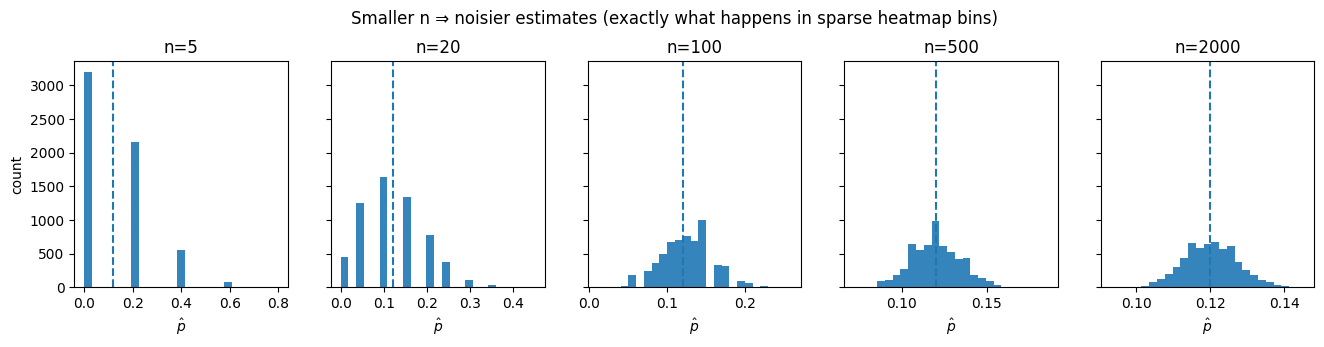

In [31]:
# Plot the sampling distribution of π-hat for different n
fig, axes = plt.subplots(1, len(ns), figsize=(16, 3), sharey=True, dpi=100)

for ax, n in zip(axes, ns):
    phat = RNG.binomial(1, p_true, size=(R, n)).mean(axis=1)
    ax.hist(phat, bins=25, alpha=0.9)
    ax.axvline(p_true, linestyle="--")
    ax.set_title(f"n={n}")
    ax.set_xlabel(r"$\hat p$")
axes[0].set_ylabel("count")
plt.suptitle("Smaller n ⇒ noisier estimates (exactly what happens in sparse heatmap bins)", y=1.05)
plt.show()


## 1.2 Basketball: shot charts, heatmaps, and expected points

We'll use:
- `SHOT_MADE` as the binary outcome $Y$,
- `LOC_X`, `LOC_Y` as location features for heatmaps,
- `SHOT_TYPE` to compute point values (2 vs 3).


We'll build:
1. A shot chart (scatter)
2. A shot density heatmap
3. An empirical "make probability" heatmap $\hat p(\text{location})$
4. An expected points heatmap

In [32]:
# Clean up the NBA dataset into the columns we need

nba["MADE"] = nba["SHOT_MADE"].astype(int)

# Shot value from SHOT_TYPE (strings like '2PT Field Goal', '3PT Field Goal')
nba["SHOT_VALUE"] = nba["SHOT_TYPE"].str.extract(r"(\d)").astype(int)

# Points on the play (0 if missed)
nba["PTS"] = nba["MADE"] * nba["SHOT_VALUE"]


nba[["LOC_X","LOC_Y","MADE","SHOT_VALUE","PTS","SHOT_DISTANCE"]].head()

,LOC_X,LOC_Y,MADE,SHOT_VALUE,PTS,SHOT_DISTANCE
0,-0.4,17.35,0,2,0,12
1,1.5,30.45,1,3,3,25
2,-3.3,6.45,1,2,2,3
3,-1.0,5.75,1,2,2,1
4,-0.0,6.15,1,2,2,1


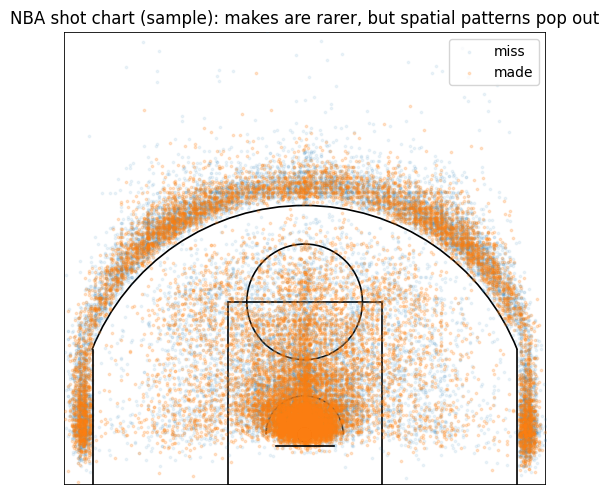

In [33]:
# Shot chart: scatter a subset, colored by make/miss

sample = nba.sample(n=min(len(nba), 40000), random_state=7)


fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
draw_nba_court(ax, color="black", lw=1.2, full=False)

made = sample[sample["MADE"]==1]
miss = sample[sample["MADE"]==0]

ax.scatter(miss["LOC_X"], miss["LOC_Y"], s=3, alpha=0.08, label="miss")
ax.scatter(made["LOC_X"], made["LOC_Y"], s=3, alpha=0.20, label="made")
ax.legend(loc="upper right")
ax.set_title("NBA shot chart (sample): makes are rarer, but spatial patterns pop out")
plt.show()

### Heatmap 1: shot density

A **density heatmap** bins the court into a grid and counts shots per bin.

- High values = places where lots of shots happen  
- Low values = places with few shots (or no data)

Why do we care?  
Because conversion rate estimates in bins with low shot counts are very noisy.



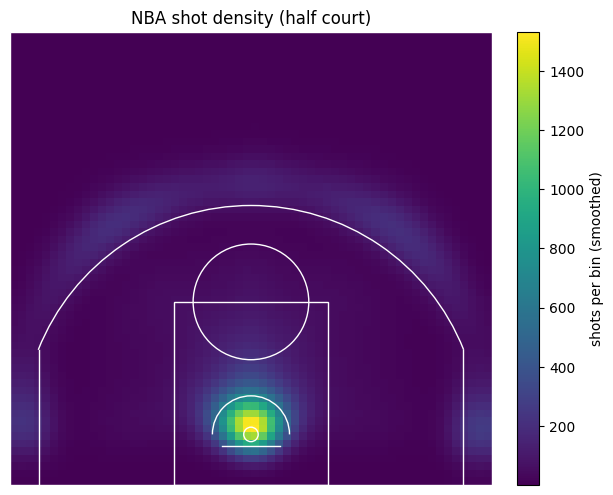

In [34]:
x = nba["LOC_X"].to_numpy()
y = nba["LOC_Y"].to_numpy()

# Use half-court view; clip to y <= 47 for a standard shot chart
mask_half = y <= 47
x_h, y_h = x[mask_half], y[mask_half]

H, xedges, yedges = heatmap2d(
    x_h, y_h,
    bins=(60, 60),
    range_=[[-25, 25], [0, 47]],
    smooth_sigma=2.0
)

fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
im = ax.imshow(
    H,
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    origin="lower",
    aspect="auto",
)
draw_nba_court(ax, color="white", lw=1.0, full=False)
ax.set_title("NBA shot density (half court)")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="shots per bin (smoothed)")
plt.show()


### Heatmap 2: conversion rate (empirical $P(\text{make}\mid\text{location})$)

In each bin:
- numerator = number of made shots
- denominator = number of attempts

Then $\hat p = \text{makes} / \text{attempts}$.

But we *hide* bins with too few attempts (e.g. fewer than 30) to avoid misleading noise.



In [35]:
made = nba["MADE"].to_numpy()

shots_grid, xedges, yedges = heatmap2d(
    x_h, y_h, bins=(60, 60), range_=[[-25, 25], [0, 47]]
)
makes_grid, _, _ = heatmap2d(
    x_h, y_h, bins=(60, 60), range_=[[-25, 25], [0, 47]], weights=made[mask_half]
)

p_make = safe_rate(makes_grid, shots_grid, min_denom=30)
p_make_smooth = gaussian_filter(np.nan_to_num(p_make, nan=0.0), sigma=1.2)
p_make_smooth = np.where(shots_grid < 5, np.nan, p_make_smooth)

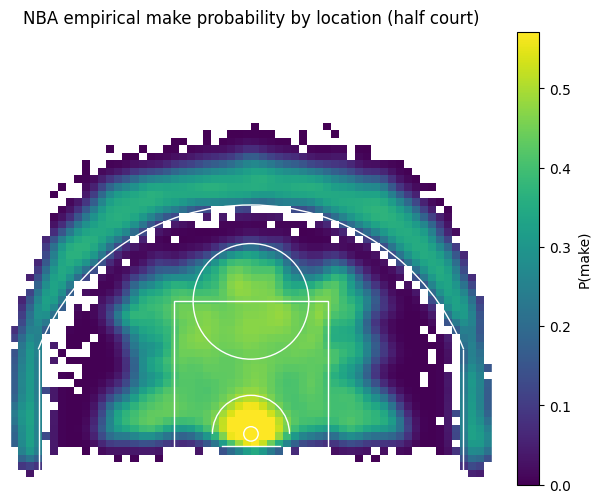

In [36]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
im = ax.imshow(
    p_make_smooth,
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    origin="lower",
    aspect="auto",
    vmin=0, vmax=np.nanpercentile(p_make_smooth, 99)
)
draw_nba_court(ax, color="white", lw=1.0, full=False)
ax.set_title("NBA empirical make probability by location (half court)")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="P(make)")
plt.show()

### Expected points (EP) / expected shot value

There are two equivalent ways to think about expected points in a bin:

1) **Average points per attempt** in that bin:
$$
\widehat{\mathbb{E}}[\text{points}\mid\text{bin}] = \frac{\sum \text{PTS}}{\#\text{attempts}}
$$

2) If every shot in a bin has the same value (2 or 3), then:
$$
\widehat{\mathbb{E}}[\text{points}\mid\text{bin}] = \text{shot\_value}\times \hat p(\text{make}\mid\text{bin}).
$$

In practice, bins can contain a mix of 2s and 3s, so we compute (1) directly.



In [37]:
pts = nba["PTS"].to_numpy()

pts_grid, xedges, yedges = heatmap2d(
    x_h, y_h, bins=(60, 60), range_=[[-25, 25], [0, 47]], weights=pts[mask_half]
)

ep = safe_rate(pts_grid, shots_grid, min_denom=30)
ep_smooth = gaussian_filter(np.nan_to_num(ep, nan=0.0), sigma=1.2)
ep_smooth = np.where(shots_grid < 5, np.nan, ep_smooth)

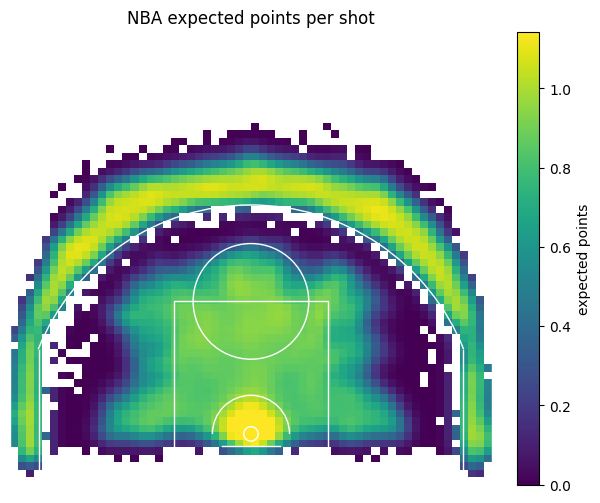

In [38]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
im = ax.imshow(
    ep_smooth,
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    origin="lower",
    aspect="auto",
    vmin=0, vmax=np.nanpercentile(ep_smooth, 99)
)
draw_nba_court(ax, color="white", lw=1.0, full=False)
ax.set_title("NBA expected points per shot")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="expected points")
plt.show()

___________
## 1.3 Soccer: shot charts, heatmaps, and expected goals (xG)

Our EPL dataset includes:
- `X`, `Y` shot location in $[0,1]$ (Understat-style)
- `result` (includes `Goal`)
- `xG` provided by the source (a separate model)

We'll:
1. Plot shots on a pitch
2. Make density and conversion heatmaps
3. Use $\sum p_i$ to turn probabilities into expected goals



In [39]:
# Build a clean soccer table

soc = soc.copy()
# Outcome: goal?
soc["GOAL"] = soc["result"].isin(["Goal", "OwnGoal"]).astype(int)
soc.loc[(soc['GOAL']==1) & (soc['X']<0.3),'X'] = 1-soc.loc[(soc['GOAL']==1) & (soc['X']<0.3),'X']

# Convert coords to meters
soc["x_m"], soc["y_m"] = understat_to_meters(soc["X"].astype(float), soc["Y"].astype(float))

soc[["X","Y","x_m","y_m","result","GOAL","xG","team","minute"]].head()

,X,Y,x_m,y_m,result,GOAL,xG,team,minute
0,0.867,0.278,91.034997,18.903999,MissedShots,0,0.036473,Fulham,7
1,0.727,0.501,76.334997,34.067999,SavedShot,0,0.021440,Fulham,12
2,0.889,0.456,93.345002,31.007999,BlockedShot,0,0.037385,Fulham,13
3,0.971,0.673,101.954998,45.764002,MissedShots,0,0.050078,Manchester United,19
4,0.747,0.479,78.434997,32.572001,MissedShots,0,0.020807,Manchester United,26


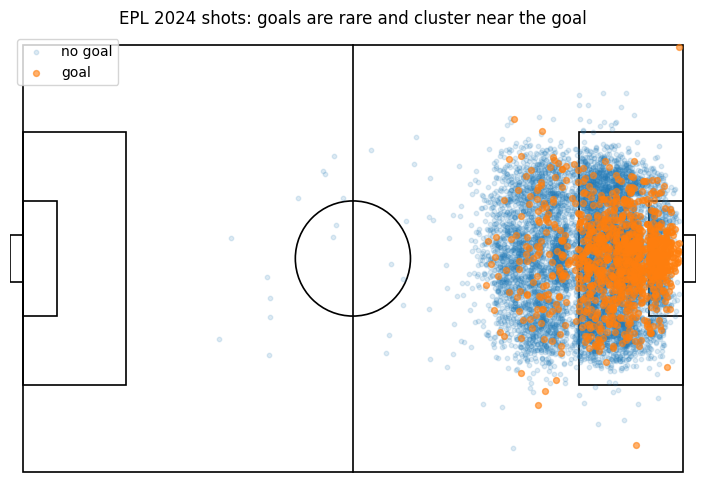

In [40]:
# Soccer shot chart (all shots, goal vs no goal)

fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
draw_soccer_pitch(ax, color="black", lw=1.2)

goal = soc[soc["GOAL"]==1]
nog  = soc[soc["GOAL"]==0]

ax.scatter(nog["x_m"], nog["y_m"], s=10, alpha=0.15, label="no goal")
ax.scatter(goal["x_m"], goal["y_m"], s=18, alpha=0.60, label="goal")
ax.legend(loc="upper left")
ax.set_title("EPL 2024 shots: goals are rare and cluster near the goal")
plt.show()


### Soccer density heatmap

Same idea as basketball: bin and count.

We'll use a $70\times 45$ grid (roughly ~1.5m by ~1.5m bins on a 105×68 pitch).


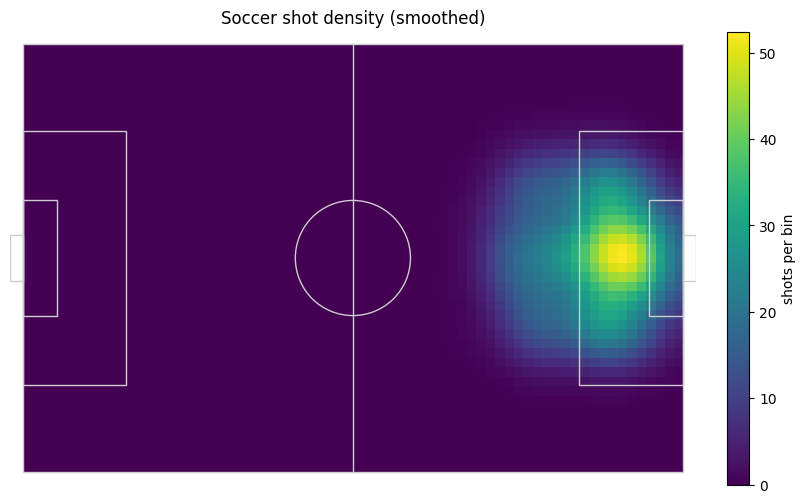

In [41]:
xs = soc["x_m"].to_numpy()
ys = soc["y_m"].to_numpy()
g  = soc["GOAL"].to_numpy()

shots_grid_s, xedges_s, yedges_s = heatmap2d(
    xs, ys, bins=(70, 45), range_=[[0, SOCCER_LENGTH_M], [0, SOCCER_WIDTH_M]],
    smooth_sigma=2.0
)

fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
im = ax.imshow(
    shots_grid_s,
    extent=[xedges_s[0], xedges_s[-1], yedges_s[0], yedges_s[-1]],
    origin="lower",
    aspect="auto",
)
draw_soccer_pitch(ax, color=".8", lw=1.0)
ax.set_title("Soccer shot density (smoothed)")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="shots per bin")
plt.show()


### Soccer conversion heatmap: empirical $P(\text{goal} \mid \text{location})$

In each bin:
$$
\hat p = \frac{\#\text{goals}}{\#\text{shots}}.
$$

We'll:
- hide bins with too few shots,
- optionally smooth in space (because nearby locations should have similar probabilities).

In [42]:
goals_grid_s, _, _ = heatmap2d(
    xs, ys, bins=(70, 45), range_=[[0, SOCCER_LENGTH_M], [0, SOCCER_WIDTH_M]], weights=g
)

p_goal = safe_rate(goals_grid_s, shots_grid_s, min_denom=8)

p_goal_smooth = gaussian_filter(np.nan_to_num(p_goal, nan=0.0), sigma=1.2)
p_goal_smooth = np.where(shots_grid_s < 1, np.nan, p_goal_smooth)


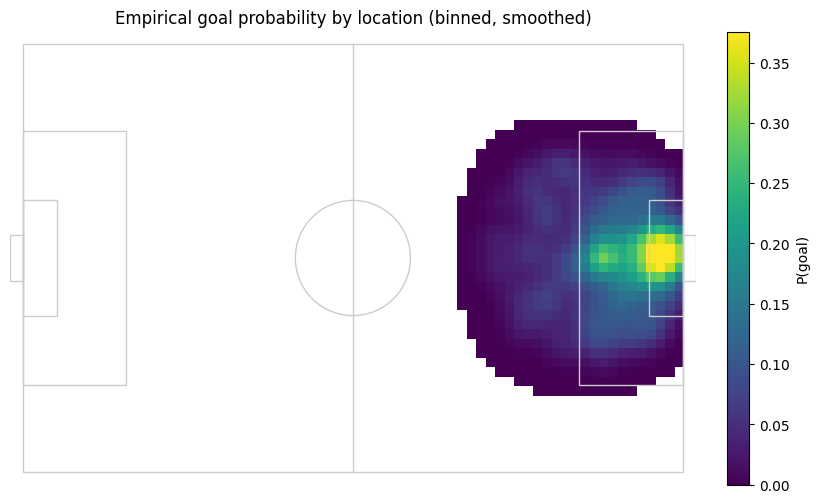

In [43]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
im = ax.imshow(
    p_goal_smooth,
    extent=[xedges_s[0], xedges_s[-1], yedges_s[0], yedges_s[-1]],
    origin="lower",
    aspect="auto",
    vmin=0, vmax=np.nanpercentile(p_goal_smooth, 99)
)
draw_soccer_pitch(ax, color=".8", lw=1.0)
ax.set_title("Empirical goal probability by location (binned, smoothed)")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="P(goal)")
plt.show()

### 1.3.1 (Optional but useful) Beta–Binomial smoothing for binned xG maps

Spatial smoothing is intuitive, but it can blur strong local signals.

A second (complementary) idea is **shrinkage**: treat each bin's conversion probability as unknown $p$ and place a Beta prior:

$$
p \sim \text{Beta}(\alpha_0, \beta_0)
$$

If a bin has $g$ goals out of $n$ shots, then the posterior is:

$$
p \mid \text{data} \sim \text{Beta}(\alpha_0 + g,\; \beta_0 + (n-g))
$$

A very convenient summary is the **posterior mean**:

$$
\mathbb{E}[p\mid\text{data}] = \frac{\alpha_0 + g}{\alpha_0 + \beta_0 + n}.
$$

This does two things automatically:
- bins with small $n$ get pulled toward the global mean,
- bins with large $n$ look close to the empirical rate.

The parameter $\kappa = \alpha_0+\beta_0$ behaves like a number of **pseudo-shots**.

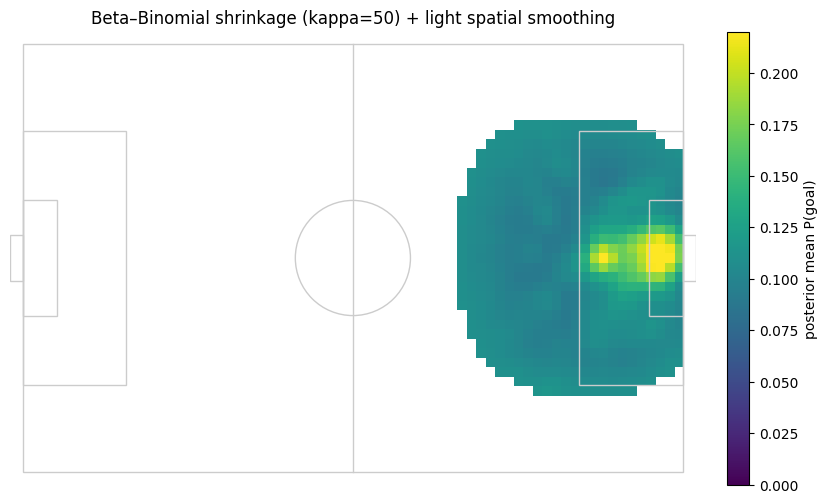

In [44]:
global_rate = soc["GOAL"].mean()
kappa = 50  # pseudo-shot strength (try 10, 50, 200)

alpha0 = global_rate * kappa
beta0  = (1 - global_rate) * kappa

alpha_post = goals_grid_s + alpha0
beta_post  = (shots_grid_s - goals_grid_s) + beta0

p_beta = alpha_post / (alpha_post + beta_post)

# Optional: spatial smoothing after shrinkage
p_beta_smooth = gaussian_filter(p_beta, sigma=1.0)
p_beta_smooth = np.where(shots_grid_s < 1, np.nan, p_beta_smooth)

fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
im = ax.imshow(
    p_beta_smooth,
    extent=[xedges_s[0], xedges_s[-1], yedges_s[0], yedges_s[-1]],
    origin="lower",
    aspect="auto",
    vmin=0, vmax=np.nanpercentile(p_beta_smooth, 99)
)
draw_soccer_pitch(ax, color=".8", lw=1.0)
ax.set_title(f"Beta–Binomial shrinkage (kappa={kappa}) + light spatial smoothing")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="posterior mean P(goal)")
plt.show()

# Uncertainty: 95% CI width in each bin
lo = beta_dist.ppf(0.025, alpha_post, beta_post)
hi = beta_dist.ppf(0.975, alpha_post, beta_post)
ci_width = np.where(shots_grid_s < 2, np.nan, (hi - lo))

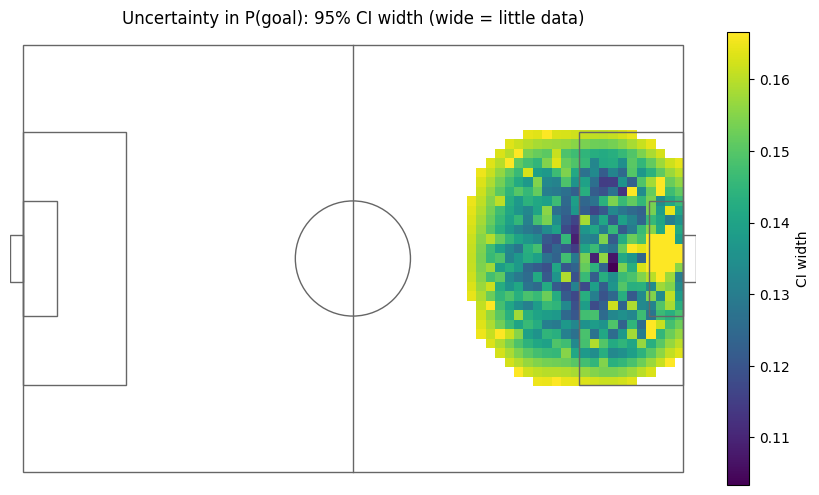

In [45]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
im = ax.imshow(
    ci_width,
    extent=[xedges_s[0], xedges_s[-1], yedges_s[0], yedges_s[-1]],
    origin="lower",
    aspect="auto",
    vmax=np.nanpercentile(ci_width, 95),
)
draw_soccer_pitch(ax, color=".4", lw=1.0)
ax.set_title("Uncertainty in P(goal): 95% CI width (wide = little data)")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="CI width")
plt.show()

### From probabilities to xG totals (linearity of expectation)

If shot $i$ has goal probability $p_i$, then the expected number of goals from $n$ shots is:

$$
\text{xG} = \sum_{i=1}^n p_i.
$$

We can compute a **naive binned xG** by looking up each shot's bin probability and summing.

This is intentionally "crude" — it's here to make the expectation idea concrete.



In [46]:
# Build a lookup table for the smoothed binned probabilities (we'll use p_beta_smooth)
p_map = p_beta_smooth  # choose which surface you want

# Which bin did each shot fall into?
xbin = np.clip(np.digitize(xs, xedges_s) - 1, 0, p_map.shape[1]-1)
ybin = np.clip(np.digitize(ys, yedges_s) - 1, 0, p_map.shape[0]-1)

p_hat = p_map[ybin, xbin]
p_hat = np.where(np.isnan(p_hat), global_rate, p_hat)  # fallback in empty bins

xg_binned = float(np.sum(p_hat))
xg_true_goals = int(soc["GOAL"].sum())
xg_source = float(soc["xG"].sum())

print("Naive binned xG (this notebook):", round(xg_binned, 2))
print("Actual goals in data:", xg_true_goals)
print("Provided xG sum (source model):", round(xg_source, 2))


Naive binned xG (this notebook): 1216.37
Actual goals in data: 1115
Provided xG sum (source model): 1236.54


# Part 2 — Logistic regression (done properly)

Heatmaps are great for seeing patterns, but they have limits:
- probabilities are **piecewise constant** in bins,
- many bins have too little data,
- adding context (angle, shot type, defenders, etc.) becomes awkward.

So we want a **smooth probability model**:

- Inputs (features): $x\in\mathbb{R}^d$  
- Binary outcome: $y\in\{0,1\}$  
- Output: $p(x) = P(Y=1\mid x)$

## A quick historical note (because it's fun)
- The **logistic function** shows up in population dynamics via Pierre-François Verhulst (1838), as a "growth with saturation" curve.
- The **logit** (log-odds) transform and logistic regression were popularized in statistics by Joseph Berkson (1940s) in bioassay work.
- Logistic regression became a workhorse because it's **interpretable**, **convex** (nice optimization), and outputs **probabilities**.

(References with links are at the end.)



## 2.1 The logistic model: turn a linear "score" into a probability

We are modeling **binary outcomes**. For each shot $i$:

- $y_i \in \{0,1\}$ is the observed outcome  
  (soccer: $y_i=1$ means *goal*, basketball: $y_i=1$ means *made shot*).
- $x_i \in \mathbb{R}^d$ is a feature vector (distance, angle, shot type, …).
- $p_i = P(Y_i=1\mid x_i)$ is the model's predicted probability of success.

### Why we *don't* model $p$ with a straight line
A naive attempt would be $p(x) = \beta_0 + \beta^\top x$.  
But probabilities must stay in $[0,1]$, while a line can go below 0 or above 1.

### The key trick: model something *unbounded*, then map it back to $(0,1)$
Logistic regression introduces a **linear predictor** (a real-valued score):

$$
\eta_i = \beta_0 + x_i^\top \beta.
$$

**Every symbol, defined:**
- $\eta_i$ is the linear score for shot $i$ (any real number).
- $\beta_0$ is the intercept (baseline log-odds when all features are 0).
- $\beta \in \mathbb{R}^d$ is a vector of coefficients.
- $x_i^\top \beta = \sum_{j=1}^d \beta_j x_{ij}$ is the dot product.

Then we map $\eta_i$ to a probability using the **sigmoid**:

$$
p_i = \sigma(\eta_i) = \frac{1}{1+e^{-\eta_i}}.
$$

**Why this form makes sense (intuition):**
- $\eta_i \to +\infty$ gives $p_i \to 1$ (almost surely a goal/make).
- $\eta_i \to -\infty$ gives $p_i \to 0$ (almost surely miss/no goal).
- Any real number $\eta_i$ becomes a valid probability in $(0,1)$.

### Odds, log-odds, and the "logit" (the most important interpretation tool)
For any probability $p\in(0,1)$ define:

$$
\text{odds}(p) = \frac{p}{1-p},
\qquad
\text{logit}(p) = \log\left(\frac{p}{1-p}\right).
$$

The sigmoid and logit are **inverses** of each other, so logistic regression is equivalently:

$$
\text{logit}(p_i) = \eta_i = \beta_0 + x_i^\top \beta.
$$

This "log-odds are linear" view is what makes the coefficients easy to explain.

**Symbol → code mapping (you'll see this repeatedly):**
- $x_i$ corresponds to a row of a feature matrix like `X` (or `X_train`).
- $\beta$ corresponds to a learned coefficient vector.
- $\eta$ is usually computed as `eta = beta0 + X @ beta`.
- $p = \sigma(\eta)$ is computed as `p = sigmoid(eta)`.

In the next cell, we'll compute a tiny numeric example of all of this on toy inputs.


Toy example (not fit to data):
  beta0 = -2.0
  beta  = [-0.08  1.3 ]
  x     = [20.    0.35]   # [dist (m), angle (rad)]
  eta   = -3.145   # linear predictor
  p     = 0.0413   # sigma(eta) = predicted probability


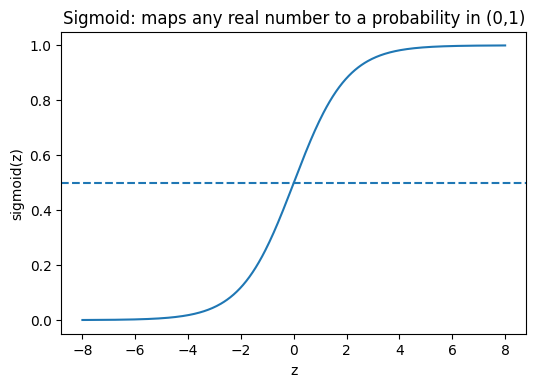

In [47]:
def sigmoid(z):
    """Compute the logistic sigmoid function.

    Mathematical definition:
        $$
        \sigma(z) = \frac{1}{1+e^{-z}}.
        $$

    Notes:
    - Accepts a scalar or a NumPy array.
    - Uses a numerically stable implementation (avoids overflow for large |z|).
    """
    z = np.asarray(z, dtype=float)

    out = np.empty_like(z, dtype=float)
    pos = z >= 0
    out[pos] = 1.0 / (1.0 + np.exp(-z[pos]))

    expz = np.exp(z[~pos])
    out[~pos] = expz / (1.0 + expz)
    return out

# -----------------------------
# Tiny numeric example: eta -> p
# -----------------------------
# We'll pretend our features are:
#   x = [distance_in_meters, open_angle_in_radians]
# and we choose some toy coefficients (NOT fit to data yet).
beta0 = -2.0
beta = np.array([-0.08, 1.30])   # [-0.08 per meter, +1.30 per radian]
x = np.array([20.0, 0.35])       # 20m from goal, 0.35 rad open angle

# Symbol -> code mapping:
#   eta = beta0 + x^T beta
eta = beta0 + x @ beta
p = sigmoid(eta)

print("Toy example (not fit to data):")
print("  beta0 =", beta0)
print("  beta  =", beta)
print("  x     =", x, "  # [dist (m), angle (rad)]")
print("  eta   =", round(float(eta), 4), "  # linear predictor")
print("  p     =", round(float(p), 4), "  # sigma(eta) = predicted probability")

# Micro-check: logit(p) should recover eta
odds = p / (1 - p)
logit_p = np.log(odds)
assert np.allclose(logit_p, eta), "Sanity check failed: logit(sigmoid(eta)) should equal eta."

# Visualize the sigmoid (build intuition)
z = np.linspace(-8, 8, 401)

fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
ax.plot(z, sigmoid(z))
ax.axhline(0.5, linestyle="--")
ax.set_title("Sigmoid: maps any real number to a probability in (0,1)")
ax.set_xlabel("z")
ax.set_ylabel("sigmoid(z)")
plt.show()


### 2.1.1 Identities you may come across

From now on we'll use:
- $z$ (or $\eta$) for the **linear predictor** $\beta_0 + x^\top\beta$,
- $p = \sigma(z)$ for the corresponding probability.

In code you will literally see this as:
- `eta = beta0 + X @ beta`
- `p = sigmoid(eta)`

Here are the four algebra facts you'll use over and over.

If
$$
p = \sigma(z) = \frac{1}{1+e^{-z}},
$$
then:

1) The complement:
$$
1-p = \frac{e^{-z}}{1+e^{-z}}
$$

2) Odds:
$$
\frac{p}{1-p} = e^{z}
$$

3) Logit (log-odds):
$$
\log\left(\frac{p}{1-p}\right) = z
$$

4) Derivative (this is the "magic" behind simple gradients):
$$
\frac{d}{dz}\sigma(z) = \sigma(z)(1-\sigma(z)) = p(1-p).
$$

We'll do a tiny numerical derivative check next, just to make this feel real.


In [48]:
# Micro-check: numerical derivative vs analytic identity sigma'(z) = sigma(z)(1-sigma(z))

z0 = np.array([-2.0, 0.0, 2.0])
eps = 1e-6

num = (sigmoid(z0 + eps) - sigmoid(z0 - eps)) / (2 * eps)
p0 = sigmoid(z0)
anal = p0 * (1 - p0)

df_check = pd.DataFrame({
    "z": z0,
    "sigma(z)": p0,
    "numerical d/dz sigma(z)": num,
    "analytic sigma(z)(1-sigma(z))": anal,
    "abs diff": np.abs(num - anal),
})
df_check


,z,sigma(z),numerical d/dz sigma(z),analytic sigma(z)(1-sigma(z)),abs diff
0,-2.0,0.119203,0.104994,0.104994,1.282141e-12
1,0.0,0.500000,0.250000,0.250000,7.188916e-12
2,2.0,0.880797,0.104994,0.104994,2.209893e-11


### 2.1.2 Tiny numerical example: probability ↔ odds ↔ log-odds

People often ask: "Why do we need odds and log-odds at all?"

Because:
- probabilities live in $(0,1)$,
- log-odds live on $(-\infty,\infty)$,
- a linear model *wants* something unbounded.

Let's convert a few probabilities back and forth.

Recall:
$$
\text{odds}(p) = \frac{p}{1-p}, \qquad \text{logit}(p) = \log\left(\frac{p}{1-p}\right).
$$

And the inverse (go back from logit $z$ to probability):
$$
p = \sigma(z) = \frac{1}{1+e^{-z}}.
$$


In [49]:
ps = np.array([0.01, 0.10, 0.20, 0.50, 0.80, 0.90, 0.99])
odds = ps / (1-ps)
logit = np.log(odds)
back = sigmoid(logit)

pd.DataFrame({
    "p": ps,
    "odds = p/(1-p)": odds,
    "logit(p)": logit,
    "sigmoid(logit(p))": back
})


,p,odds = p/(1-p),logit(p),sigmoid(logit(p))
0,0.01,0.010101,-4.595120,0.01
1,0.10,0.111111,-2.197225,0.10
2,0.20,0.250000,-1.386294,0.20
3,0.50,1.000000,0.000000,0.50
4,0.80,4.000000,1.386294,0.80
5,0.90,9.000000,2.197225,0.90
6,0.99,99.000000,4.595120,0.99


### 2.1.3 Decision boundary intuition (classification vs probabilities)

Logistic regression is a **probability model**, but you can turn it into a classifier by thresholding:
- predict class 1 if $p(x) \ge t$ (often $t=0.5$).

In feature space, the set of points where $p(x)=0.5$ is where the logit is zero:

$$
p(x)=0.5 \iff \beta_0 + \beta^\top x = 0.
$$

That's a **hyperplane**. In 2D it's a line; in 3D it's a plane.

Below is a toy example to make that visual.


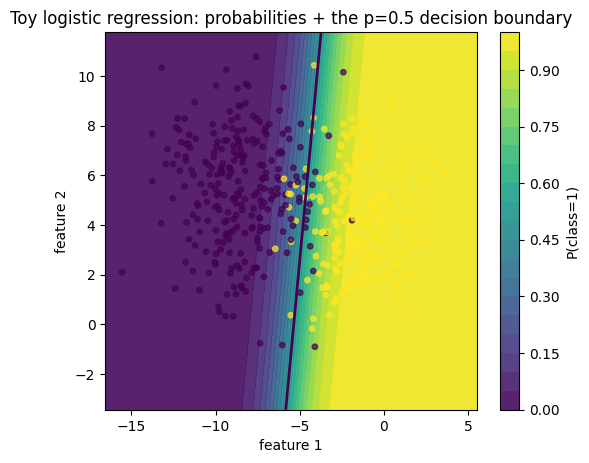

In [50]:
from sklearn.datasets import make_blobs

# Toy data: two blobs in 2D
Xtoy, ytoy = make_blobs(
    n_samples=500,
    centers=2,
    random_state=7,
    cluster_std=2.3
)

toy = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=500))
])
toy.fit(Xtoy, ytoy)

# Grid for decision surface
x0 = np.linspace(Xtoy[:, 0].min() - 1, Xtoy[:, 0].max() + 1, 200)
x1 = np.linspace(Xtoy[:, 1].min() - 1, Xtoy[:, 1].max() + 1, 200)
X0, X1 = np.meshgrid(x0, x1)

P = toy.predict_proba(np.c_[X0.ravel(), X1.ravel()])[:, 1].reshape(X0.shape)
assert np.all((P >= 0) & (P <= 1)), "Probabilities must be in [0,1]."

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
cf = ax.contourf(X0, X1, P, levels=20, alpha=0.9)
fig.colorbar(cf, ax=ax, label="P(class=1)")

# Decision boundary is where P=0.5
ax.contour(X0, X1, P, levels=[0.5], linewidths=2)

ax.scatter(Xtoy[:, 0], Xtoy[:, 1], c=ytoy, s=15, alpha=0.7)
ax.set_title("Toy logistic regression: probabilities + the p=0.5 decision boundary")
ax.set_xlabel("feature 1")
ax.set_ylabel("feature 2")
plt.show()


### 2.2 Log loss: the natural loss for Bernoulli outcomes

"Why not mean squared error?"

Because for binary data, the math of probability (likelihood) gives you a loss function "for free".

For one example with:
- true label $y \in \{0,1\}$,
- predicted probability $p \in (0,1)$ for the event $y=1$,

the Bernoulli likelihood is $p^y(1-p)^{1-y}$. Taking negative logs gives the *log loss*:

$$
\text{logloss}(p, y) = -\Big[y\log(p) + (1-y)\log(1-p)\Big].
$$


**Every symbol, defined:**
- $y=1$ means the event happened (goal/make), $y=0$ means it did not.
- $p$ is the model's predicted probability that $y=1$.
- $\log$ is the natural log.

**Why this form makes sense (intuition):**
- If $y=1$, then $\text{logloss}(p,1) = -\log(p)$, so higher $p$ is better.
- If $y=0$, then $\text{logloss}(p,0) = -\log(1-p)$, so lower $p$ is better.
- It punishes being **confident and wrong**: predicting $p=0.01$ when $y=1$ gives a huge loss.

**Symbol → code mapping (next cell):**
- $p$ becomes the function input `p`
- $y$ becomes the function input `y`
- the formula above is implemented in `logloss_one(p, y)`

Next, we compute the loss for a few simple probabilities so you can *feel* the numbers.


In [51]:
def logloss_one(p, y, eps=1e-12):
    """Log loss for a single Bernoulli observation.

    Implements:
        $$\text{logloss}(p,y) = -[y\log p + (1-y)\log(1-p)].$$

    Parameters
    ----------
    p : float
        Predicted probability for y=1.
    y : int
        True label in {0,1}.
    eps : float
        Small number to avoid log(0).

    Returns
    -------
    float
        The log loss value.
    """
    p = float(np.clip(p, eps, 1 - eps))
    y = int(y)
    return -(y * np.log(p) + (1 - y) * np.log(1 - p))

# Tiny sanity checks with known values
assert abs(logloss_one(0.5, 1) - 0.6931471805599453) < 1e-9
assert abs(logloss_one(0.5, 0) - 0.6931471805599453) < 1e-9

ps = np.array([0.01, 0.05, 0.10, 0.50, 0.90, 0.95, 0.99])
loss_y1 = [logloss_one(p, 1) for p in ps]
loss_y0 = [logloss_one(p, 0) for p in ps]

pd.DataFrame({
    "p": ps,
    "loss if y=1 (=-log p)": loss_y1,
    "loss if y=0 (=-log(1-p))": loss_y0
})


,p,loss if y=1 (=-log p),loss if y=0 (=-log(1-p))
0,0.01,4.605170,0.010050
1,0.05,2.995732,0.051293
2,0.10,2.302585,0.105361
3,0.50,0.693147,0.693147
4,0.90,0.105361,2.302585
5,0.95,0.051293,2.995732
6,0.99,0.010050,4.605170


### 2.1.2 How to interpret coefficients: log-odds and odds ratios

One reason people love logistic regression is that the coefficients have a clean interpretation.

Start with the model written in log-odds form:

$$
\log\left(\frac{p}{1-p}\right) = \beta_0 + \beta_1 x_1 + \cdots + \beta_d x_d.
$$

**Every symbol, defined:**
- $p$ is shorthand for $p(x) = P(Y=1\mid x)$, the predicted probability of a goal/make.
- $x_j$ is the $j$-th feature (for example: distance, angle, a 0/1 indicator for "header", …).
- $\beta_j$ is the coefficient multiplying feature $x_j$.
- $\beta_0$ is the intercept (baseline log-odds when $x=0$).

**Interpretation (the key step):**
If you increase feature $x_j$ by **1 unit** (holding the other features fixed), the right-hand side increases by $\beta_j$.
Because the left-hand side is a log, exponentiating turns "additive in log-odds" into "multiplicative in odds":

$$
\text{odds}(p) = \frac{p}{1-p}
\quad\Rightarrow\quad
\text{odds} \text{ get multiplied by } \exp(\beta_j) \text{ when } x_j \text{ increases by 1}.
$$

**Tiny numeric example:**
- If $\beta_j = 0.7$, then $\exp(0.7)\approx 2.01$, so the odds roughly **double**.
- If $\beta_j = -0.7$, then $\exp(-0.7)\approx 0.50$, so the odds roughly **halve**.

**Why the "unit" matters:**
- For soccer, a "1 meter" increase in distance is small.
- A "1 radian" increase in angle is huge (almost 57 degrees).

So we often interpret odds ratios for meaningful increments (like +5 meters), not just +1.
Later, we'll compute those odds ratios directly from the fitted model.


## 2.2 Training logistic regression = maximum likelihood

At this point we have:
- observed labels $y_i \in \{0,1\}$,
- predicted probabilities $p_i = P(Y_i=1\mid x_i)$ from the logistic model.

### Step 1: the Bernoulli probability of what we actually observed
For one data point $(x_i, y_i)$, the Bernoulli probability mass function can be written compactly as:

$$
P(Y_i=y_i\mid x_i) = p_i^{y_i}(1-p_i)^{1-y_i}.
$$

**Why this clever exponent form works:**
- If $y_i=1$, then $p_i^{y_i}(1-p_i)^{1-y_i} = p_i^1(1-p_i)^0 = p_i$.
- If $y_i=0$, then it becomes $p_i^0(1-p_i)^1 = 1-p_i$.

So the single equation covers both cases.

### Step 2: multiply across shots (an assumption!)
If we assume shots are conditionally independent given the features (a standard modeling assumption), the likelihood of the whole dataset is:

$$
L(\beta_0,\beta) = \prod_{i=1}^n p_i^{y_i}(1-p_i)^{1-y_i}.
$$

Here:
- $n$ is the number of shots,
- $\beta_0,\beta$ are the parameters we want to learn.

### Step 3: take logs to get a sum (much easier to optimize)
Taking logs turns the product into a sum:

$$
\ell(\beta_0,\beta) = \log L(\beta_0,\beta)
= \sum_{i=1}^n \Big[y_i\log p_i + (1-y_i)\log(1-p_i)\Big].
$$

We **maximize** the log-likelihood $\ell$.

Equivalently, we **minimize** the negative log-likelihood (NLL):

$$
\text{NLL}(\beta_0,\beta)
= -\sum_{i=1}^n \Big[y_i\log p_i + (1-y_i)\log(1-p_i)\Big].
$$

Notice this is exactly the same expression as log loss, just summed over $i$.

### Symbol → code mapping
- $y_i$ becomes a NumPy array / pandas Series like `y_train`.
- $p_i$ becomes the predicted probability vector like `p_test`.
- `sklearn.metrics.log_loss(y, p)` returns the **mean** log loss (average over $i$).
  If you multiply it by $n$, you get the total NLL up to numerical clipping.

We'll verify that relationship with a tiny toy example next.

### Regularization (why scikit-learn does it by default)
Many ML libraries fit a *regularized* objective to reduce overfitting:

$$
\text{Objective} = \text{NLL}(\beta_0,\beta) + \lambda\|\beta\|_2^2.
$$

- $\lambda \ge 0$ is the regularization strength (bigger means "shrink coefficients more").
- $\|\beta\|_2^2 = \sum_{j=1}^d \beta_j^2$ is the squared L2 norm.

`statsmodels` (by default) fits the **unregularized** MLE, which is why it's the go-to for standard errors and hypothesis tests.


In [52]:
# Tiny numeric example: NLL is the sum of log losses

y_toy = np.array([1, 0, 1, 0])
p_toy = np.array([0.90, 0.20, 0.60, 0.10])

# Manual negative log-likelihood (NLL)
nll_manual = -np.sum(y_toy * np.log(p_toy) + (1 - y_toy) * np.log(1 - p_toy))

# sklearn's log_loss is the MEAN log loss by default
logloss_mean = log_loss(y_toy, p_toy)

print("Toy labels y:", y_toy)
print("Toy probs  p:", p_toy)
print("Manual NLL (sum over i):", round(float(nll_manual), 6))
print("sklearn log_loss (mean):", round(float(logloss_mean), 6))
print("mean * n:", round(float(logloss_mean * len(y_toy)), 6))

assert abs(nll_manual - logloss_mean * len(y_toy)) < 1e-10


Toy labels y: [1 0 1 0]
Toy probs  p: [0.9 0.2 0.6 0.1]
Manual NLL (sum over i): 0.94469
sklearn log_loss (mean): 0.236173
mean * n: 0.94469


## 2.3 A simple xG model with logistic regression (soccer)

Now we'll build a classic "geometry-only" xG model: predict $P(\text{goal})$ using only where the shot was taken.

We'll use two features that capture most of the *location* signal:

- **Distance to goal** (meters): farther shots are harder.
- **Open angle to the goal** (radians): sharper angles are harder.

### Step 1: define the coordinate system (so the geometry is unambiguous)
Our soccer data uses Understat-style coordinates:
- raw columns `X` and `Y` are in $[0,1]$,
- we convert to meters on a $105\times 68$ pitch:
  - `x_m = X * 105`
  - `y_m = Y * 68`

We treat the attacking goal as the one on the **right**:
- goal center is at $(105, 34)$ (meters),
- goal posts are at $(105, 34 \pm 3.66)$ because the goal width is 7.32m.

### Step 2: distance feature (Euclidean distance to goal center)
For a shot at $(x_i, y_i)$ (in meters), define distance:

$$
d_i = \sqrt{(105-x_i)^2 + (y_i-34)^2}.
$$

**Every symbol, defined:**
- $(x_i, y_i)$ = shot location in meters,
- $d_i$ = distance to goal center in meters,
- 105 and 34 come from pitch length and half the pitch width.

**Why this form makes sense:** it is just the standard Euclidean distance formula.

### Step 3: open-angle feature (how much goal you can "see")
Intuition: if you draw two lines from the ball to the two goal posts, the open angle is the angle between those two lines.

A common way to compute it is:
1. compute the angle to the *lower* post,
2. compute the angle to the *upper* post,
3. take the absolute difference.

In code we do this in `soccer_distance_angle(x_m, y_m)`, which returns:
- `dist` = $d_i$
- `angle` = open angle (radians)

Next we'll draw one example shot and visually confirm what "open angle" means.


### Geometry check: what does "open angle" mean?

For one shot location, we draw lines to the two posts.
The **open angle** is the angle between those two lines.

Intuition:
- if you are near the endline at a sharp angle, the open angle is tiny,
- if you are central and close, the open angle is large.



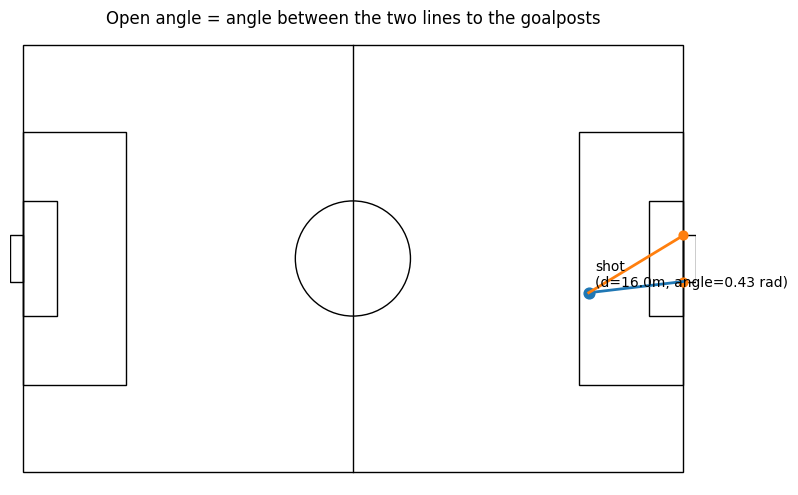

In [53]:
# Pick a representative shot (median distance in the dataset)
x_all = soc["x_m"].to_numpy()
y_all = soc["y_m"].to_numpy()
dist_all, ang_all = soccer_distance_angle(x_all, y_all)

i = int(np.argsort(dist_all)[len(dist_all)//2])
x0, y0 = float(x_all[i]), float(y_all[i])
d0, a0 = float(dist_all[i]), float(ang_all[i])

goal_x = SOCCER_LENGTH_M
goal_y = SOCCER_WIDTH_M/2
post1 = (goal_x, goal_y - GOAL_WIDTH_M/2)
post2 = (goal_x, goal_y + GOAL_WIDTH_M/2)

fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
draw_soccer_pitch(ax, color="black", lw=1.0)

# Shot point
ax.scatter([x0], [y0], s=60)
ax.text(x0+1, y0+1, f"shot\n(d={d0:.1f}m, angle={a0:.2f} rad)", fontsize=10)

# Lines to posts
ax.plot([x0, post1[0]], [y0, post1[1]], linewidth=2)
ax.plot([x0, post2[0]], [y0, post2[1]], linewidth=2)

# Mark posts
ax.scatter([post1[0], post2[0]], [post1[1], post2[1]], s=40)

ax.set_title("Open angle = angle between the two lines to the goalposts")
plt.show()


In [54]:
# Build feature columns
dist, ang = soccer_distance_angle(soc["x_m"].to_numpy(), soc["y_m"].to_numpy())
soc["dist"] = dist
soc["angle"] = ang

# A couple of helpful transforms (log distance is common)
soc["log_dist"] = np.log1p(soc["dist"])  # log(1+dist) avoids log(0)

soc[["dist","angle","log_dist","GOAL","xG"]].describe()


,dist,angle,log_dist,GOAL,xG
count,9878.000000,9878.000000,9878.000000,9878.000000,9878.000000
mean,16.796163,0.464848,2.782334,0.112877,0.125181
std,7.436660,0.288429,0.461232,0.316459,0.167522
min,0.840003,0.004117,0.609767,0.000000,0.000000
25%,11.180055,0.274813,2.499800,0.000000,0.031771
50%,15.969504,0.364684,2.831418,0.000000,0.059666
75%,22.057731,0.563807,3.138001,0.000000,0.110777
max,74.913849,2.690389,4.329599,1.000000,0.979322


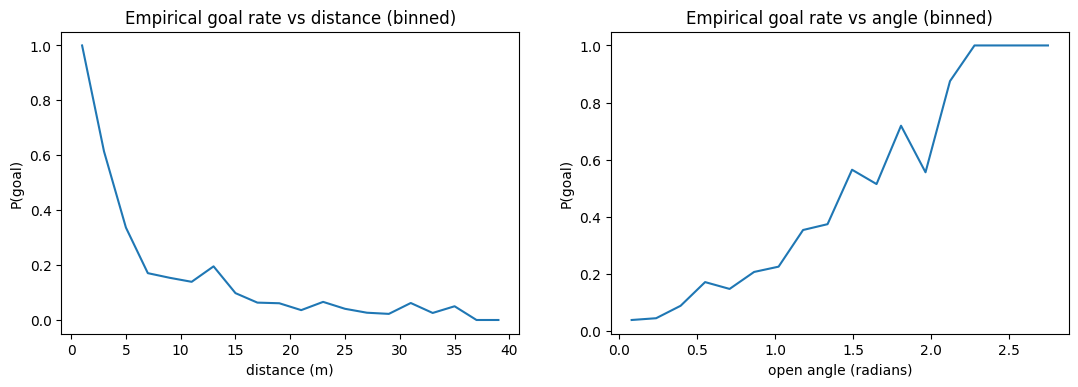

In [55]:
# Quick intuition plots: goal rate vs distance and angle

# Bin distance
soc_tmp = soc.copy()
soc_tmp["dist_bin"] = pd.cut(soc_tmp["dist"], bins=np.linspace(0, 40, 21), include_lowest=True)
rate_by_dist = soc_tmp.groupby("dist_bin")["GOAL"].mean()

# Bin angle
soc_tmp["ang_bin"] = pd.cut(soc_tmp["angle"], bins=np.linspace(0, np.pi, 21), include_lowest=True)
rate_by_ang = soc_tmp.groupby("ang_bin")["GOAL"].mean()

fig, axes = plt.subplots(1, 2, figsize=(13, 4), dpi=100)
axes[0].plot(np.linspace(1, 39, len(rate_by_dist)), rate_by_dist.to_numpy())
axes[0].set_title("Empirical goal rate vs distance (binned)")
axes[0].set_xlabel("distance (m)")
axes[0].set_ylabel("P(goal)")

axes[1].plot(np.linspace(0.08, np.pi-0.08, len(rate_by_ang)), rate_by_ang.to_numpy())
axes[1].set_title("Empirical goal rate vs angle (binned)")
axes[1].set_xlabel("open angle (radians)")
axes[1].set_ylabel("P(goal)")

plt.show()


### Step 2: baseline model (constant probability)

Before fitting anything fancy, establish a baseline probability: "always predict the overall goal rate".

$$
\hat p_{\text{base}} = \frac{\#\text{goals}}{\#\text{shots}}.
$$

**Every symbol, defined:**
- $\hat p_{\text{base}}$ is the baseline predicted probability (a single constant).
- $\#\text{goals}$ is the number of shots with $y=1$.
- $\#\text{shots}$ is the total number of shots.

**Why this matters:**
- It is the intercept-only logistic regression model.
- Any useful model should beat this baseline on **proper scoring rules** (losses that reward honest probabilities).

We'll evaluate two scoring rules:

1) **Log loss** (already defined above): lower is better; it heavily penalizes confident wrong predictions.

2) **Brier score**, which is just mean squared error on probabilities:

$$
\text{Brier} = \frac{1}{n}\sum_{i=1}^n (p_i - y_i)^2.
$$

Here:
- $p_i$ is the predicted probability for shot $i$,
- $y_i$ is the observed label (0 or 1),
- $n$ is the number of shots.

Brier is sensitive to **calibration**: if your probabilities are too extreme or too timid, Brier gets worse.

**Symbol → code mapping (next cell):**
- $y$ is `soc["GOAL"]`
- $\hat p_{\text{base}}$ is computed as `p_base = y.mean()`
- Brier is computed as `brier_score_loss(y, p_vector)`


In [56]:
y = soc["GOAL"].to_numpy()

p_base = float(y.mean())
print("Baseline goal rate:", round(p_base, 4))

# Baseline log loss on the whole dataset (for reference)
p_base_vec = np.full_like(y, p_base, dtype=float)
print("Baseline log loss:", round(log_loss(y, p_base_vec), 4))
print("Baseline Brier score:", round(brier_score_loss(y, p_base_vec), 4))


Baseline goal rate: 0.1129
Baseline log loss: 0.3525
Baseline Brier score: 0.1001


### Step 3: train/test split + fit logistic regression (scikit-learn)

We'll start with two numeric features: `dist` and `angle`.

We'll split into:
- a **training set** (used to fit the model),
- a **test set** (used only for evaluation, to estimate out-of-sample performance).

We use `stratify=y` so the goal rate is about the same in train and test.

Because scikit-learn's `LogisticRegression` applies **regularization by default**, we also:
- standardize features (so the penalty treats them comparably),
- keep the model simple and interpretable.

### Metrics we'll report (defined now, before you see the numbers)
- **Log loss**: average negative log-likelihood; lower is better (rewards honest probabilities).
- **Brier score**: mean squared error on probabilities; lower is better (very calibration-sensitive).
- **ROC-AUC**: area under the ROC curve; measures ranking quality (how well you separate goals vs non-goals).
  A useful probabilistic interpretation: ROC-AUC is the probability that a random positive example gets a higher predicted score than a random negative example.
- **PR-AUC** (average precision): area under the precision–recall curve; often more informative when positives (goals) are rare.

Important: AUC metrics care about *ranking*, not calibration. Log loss and Brier care about the *probabilities themselves*.


In [57]:
X = soc[["dist","angle"]]
y = soc["GOAL"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7, stratify=y
)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=500, solver="lbfgs"))
])

pipe.fit(X_train, y_train)

p_test = pipe.predict_proba(X_test)[:, 1]
p_train = pipe.predict_proba(X_train)[:, 1]

print("Test log loss:", round(log_loss(y_test, p_test), 4))
print("Test ROC-AUC:", round(roc_auc_score(y_test, p_test), 4))
print("Test PR-AUC:", round(average_precision_score(y_test, p_test), 4))
print("Test Brier:", round(brier_score_loss(y_test, p_test), 4))


Test log loss: 0.3191
Test ROC-AUC: 0.7144
Test PR-AUC: 0.3021
Test Brier: 0.0916


### Step 4: interpret scikit-learn coefficients (and undo standardization)

In the scikit-learn pipeline we used `StandardScaler()`, which transforms each feature into a standardized version:

$$
z = \frac{x-\mu}{\sigma}.
$$

**Every symbol, defined:**
- $x$ is an original feature value (e.g., distance in meters).
- $\mu$ is the feature mean on the training set.
- $\sigma$ is the feature standard deviation on the training set.
- $z$ is the standardized feature (units = "standard deviations from the mean").

**Why standardize here:** because scikit-learn's logistic regression uses L2 regularization by default, and regularization is sensitive to feature scale. Standardization makes the penalty treat features comparably.

If the fitted model (in standardized units) is:

$$
\eta = \beta_0 + \beta_1 z_1 + \beta_2 z_2,
$$

then the equivalent model in original units is:

$$
\eta = \tilde\beta_0 + \tilde\beta_1 x_1 + \tilde\beta_2 x_2,
$$

where the "back-transformed" coefficients are:

$$
\tilde\beta_j = \frac{\beta_j}{\sigma_j}
$$

and the intercept adjusts to account for subtracting the means.

**Symbol → code mapping (next cell):**
- $\mu$ is `scaler.mean_`
- $\sigma$ is `scaler.scale_`
- $\beta$ is `lr.coef_`
- $\tilde\beta$ is computed as `beta_orig = beta_std / sigma`


In [58]:
# Extract fitted coefficients
lr = pipe.named_steps["lr"]
scaler = pipe.named_steps["scaler"]

beta_std = lr.coef_.ravel()
intercept_std = lr.intercept_[0]

# Back-transform to original units
sigma = scaler.scale_
mu = scaler.mean_

beta_orig = beta_std / sigma
intercept_orig = intercept_std - np.sum((beta_std * mu) / sigma)

coef_table = pd.DataFrame({
    "feature": ["dist (m)", "angle (rad)"],
    "beta (standardized)": beta_std,
    "beta (original units)": beta_orig,
    "odds ratio per +1 unit": np.exp(beta_orig)
})

coef_table


,feature,beta (standardized),beta (original units),odds ratio per +1 unit
0,dist (m),-0.367652,-0.049634,0.951577
1,angle (rad),0.472768,1.645350,5.182825


### Step 4B: Logistic regression with `statsmodels` (inference + "how to read the table")

scikit-learn is excellent for **prediction** (train/test splits, cross-validation, regularization).

`statsmodels` is excellent when you want an inference-style output table:
- coefficient estimates,
- standard errors,
- z-statistics,
- p-values,
- confidence intervals.

We'll fit the same geometry-only model with `statsmodels` so we can practice reading a regression table *carefully*.

**Important caution:** these inference quantities assume the model is correctly specified (and are not "causal effects").
In sports xG, we usually interpret them as **associations**: "holding other features fixed, probability tends to change like this."


In [59]:
# statsmodels expects an explicit intercept (constant) column
X_train_sm = sm.add_constant(X_train, has_constant="add")
X_test_sm = sm.add_constant(X_test, has_constant="add")

# Lightweight sanity checks
assert X_train_sm.shape[0] == len(y_train)
assert X_test_sm.shape[0] == len(y_test)
assert "const" in X_train_sm.columns

# Fit unregularized logistic regression via MLE (maximum likelihood estimation)
logit_sm = sm.Logit(y_train, X_train_sm)
res_sm = logit_sm.fit(disp=False)

print(res_sm.summary())

# Optional: robust standard errors (HC1). Coefficients will be the same, SEs can change.
res_sm_hc1 = sm.Logit(y_train, X_train_sm).fit(disp=False, cov_type="HC1")

se_compare = pd.DataFrame({
    "SE (nonrobust)": res_sm.bse,
    "SE (HC1 robust)": res_sm_hc1.bse,
})
se_compare

# Evaluate predictive performance on the test set (same metrics as scikit-learn)
p_test_sm = res_sm.predict(X_test_sm)
p_test_sm = np.clip(p_test_sm, 1e-12, 1 - 1e-12)  # avoid log(0) in log loss

print("\nTest metrics (statsmodels fit, evaluated on the held-out test set):")
print("  Test log loss:", round(float(log_loss(y_test, p_test_sm)), 4))
print("  Test ROC-AUC :", round(float(roc_auc_score(y_test, p_test_sm)), 4))
print("  Test PR-AUC  :", round(float(average_precision_score(y_test, p_test_sm)), 4))
print("  Test Brier   :", round(float(brier_score_loss(y_test, p_test_sm)), 4))


                           Logit Regression Results                           
Dep. Variable:                   GOAL   No. Observations:                 7408
Model:                          Logit   Df Residuals:                     7405
Method:                           MLE   Df Model:                            2
Date:                Mon, 09 Feb 2026   Pseudo R-squ.:                  0.1058
Time:                        14:23:42   Log-Likelihood:                -2334.6
converged:                       True   LL-Null:                       -2610.8
Covariance Type:            nonrobust   LLR p-value:                1.091e-120
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2283      0.231     -9.651      0.000      -2.681      -1.776
dist          -0.0497      0.010     -5.047      0.000      -0.069      -0.030
angle          1.6459      0.180      9.149      0.0

#### How to read the `statsmodels` logistic regression table (every number explained)

The printed output above has two conceptual parts:

**(A) Model fit / bookkeeping (top block).**  
This tells you what was fit, on how many observations, and how much better it is than a "null" model.

**(B) The coefficient table (bottom block).**  
This tells you what parameters were learned, how uncertain they are, and whether they are distinguishable from 0.

Below we unpack *every field* you saw.

---

### A. Top block: what each line means

**Dep. Variable**  
The dependent variable $y$ (the thing we are predicting). Here it is `GOAL`, coded as 1 for goal and 0 for no-goal.

**No. Observations**  
The sample size $n$ (how many shots were used in the fit).

**Model**  
The model class. `Logit` means logistic regression with a logit link function.

**Method**  
The fitting method. `MLE` means *maximum likelihood estimation*: choose $(\beta_0,\beta)$ to maximize the probability of the observed data under the model.

**Df Model**  
The number of predictors (features) excluding the intercept.  
Example: if you have `const`, `dist`, and `angle`, then Df Model is 2 (because `dist` and `angle` are the two non-intercept predictors).

**Df Residuals**  
Roughly "how many degrees of freedom are left": $n - (k+1)$ where $k$ is Df Model and the $+1$ is the intercept.

**Log-Likelihood**  
The optimized log-likelihood value $\ell(\hat\beta_0,\hat\beta)$.  
Interpretation: higher (less negative) is better *for the same dataset*, but log-likelihood always increases as you add more parameters, so it's mainly used in comparisons.

**LL-Null**  
The log-likelihood of a *null* model (intercept-only).  
This is the baseline "just predict the overall goal rate" model.

**Pseudo R-squ.**  
For `Logit` results, `statsmodels` reports McFadden's pseudo-$R^2$:

$$
R^2_{\text{McF}} = 1 - \frac{\ell(\text{model})}{\ell(\text{null})}.
$$

It is **not** the same as the $R^2$ from linear regression, but it's a rough "how much better than null" measure. Values like 0.05–0.20 can already be meaningful in sparse sports outcomes.

**LLR p-value**  
A likelihood ratio test comparing the fitted model to the null model:
- Null hypothesis: all non-intercept coefficients are 0.
- Small p-value means "the predictors improve fit compared to intercept-only."

**converged**  
Whether the optimizer successfully converged. If `False`, you should *not* trust the estimates.

**Covariance Type**  
How standard errors were computed:
- `nonrobust` is the default model-based covariance estimate.
- `HC1` is a "robust" sandwich estimator (less sensitive to some forms of misspecification).

---

### B. Coefficient table: what each column means

Each row corresponds to one parameter:
- `const` is $\beta_0$ (intercept),
- `dist` is the coefficient for distance,
- `angle` is the coefficient for open angle.

The columns mean:

**coef**  
The estimated coefficient $\hat\beta_j$ (in log-odds units).

**std err**  
The standard error of $\hat\beta_j$, i.e., an estimate of how much $\hat\beta_j$ would vary across repeated samples.

**z**  
The z-statistic $z = \hat\beta_j / \text{SE}(\hat\beta_j)$.  
Under the "coefficient is really 0" null, this is approximately standard normal.

**P>|z|**  
A two-sided p-value for testing $H_0: \beta_j = 0$.

**[0.025 0.975]**  
A 95% confidence interval for $\beta_j$.

A key interpretation bridge is the **odds ratio**:
$$
\text{OR}_j = \exp(\hat\beta_j),
$$
which tells you how the odds change when $x_j$ increases by 1 unit (holding the other variables fixed).

Next we'll compute odds ratios, confidence intervals, and a few "plain English" effect sizes from the fitted model.


In [60]:
prsquared_check = 1 - res_sm.llf / res_sm.llnull
assert np.allclose(prsquared_check, res_sm.prsquared)

rows = [
    ("No. Observations (n)", int(res_sm.nobs),
     "How many shots were used in the fit."),
    ("Df Model (k)", int(res_sm.df_model),
     "Number of non-intercept predictors (here: dist and angle)."),
    ("Df Residuals", int(res_sm.df_resid),
     "Roughly n - (k+1): degrees of freedom left after estimating parameters."),
    ("Log-Likelihood (llf)", float(res_sm.llf),
     "Optimized log-likelihood of the fitted model; higher is better on the same data."),
    ("LL-Null (llnull)", float(res_sm.llnull),
     "Log-likelihood of the intercept-only (baseline) model."),
    ("McFadden pseudo-R^2 (prsquared)", float(res_sm.prsquared),
     "1 - llf/llnull. A 'better than null' measure (not the same as linear-regression R^2)."),
    ("LLR p-value (llr_pvalue)", float(res_sm.llr_pvalue),
     "Likelihood ratio test p-value vs the null model; tiny means predictors improve fit."),
    ("Converged?", bool(res_sm.mle_retvals.get('converged', True)),
     "Did the optimizer converge? If False, do not trust coefficients."),
    ("Covariance type", str(res_sm.cov_type),
     "How standard errors were computed (e.g., 'nonrobust' or 'HC1')."),
]

pd.DataFrame(rows, columns=["Field in summary", "Value", "How to interpret it"])


,Field in summary,Value,How to interpret it
0,No. Observations (n),7408,How many shots were used in the fit.
1,Df Model (k),2,Number of non-intercept predictors (here: dist...
2,Df Residuals,7405,Roughly n - (k+1): degrees of freedom left aft...
3,Log-Likelihood (llf),-2334.613668,Optimized log-likelihood of the fitted model; ...
4,LL-Null (llnull),-2610.836845,Log-likelihood of the intercept-only (baseline...
5,McFadden pseudo-R^2 (prsquared),0.105799,1 - llf/llnull. A 'better than null' measure (...
6,LLR p-value (llr_pvalue),0.0,Likelihood ratio test p-value vs the null mode...
7,Converged?,True,"Did the optimizer converge? If False, do not t..."
8,Covariance type,nonrobust,"How standard errors were computed (e.g., 'nonr..."


#### Turning log-odds coefficients into odds ratios (more interpretable)

The `coef` column is in **log-odds units**, which is not very intuitive.

A common trick is to exponentiate:
$$
\text{OR}_j = \exp(\hat\beta_j),
$$
where $\text{OR}_j$ is the **odds ratio** for a 1-unit increase in feature $x_j$ (holding other features fixed).

We'll compute:
- coefficient estimates,
- 95% confidence intervals for coefficients,
- odds ratios and their confidence intervals.


In [61]:
ci = res_sm.conf_int()
ci.columns = ["2.5%", "97.5%"]

coef_table = pd.DataFrame({
    "coef (log-odds)": res_sm.params,
    "std err": res_sm.bse,
    "z": res_sm.tvalues,
    "P>|z|": res_sm.pvalues,
    "CI 2.5%": ci["2.5%"],
    "CI 97.5%": ci["97.5%"],
})

# Micro-check: z should be coef / std err
z_check = coef_table["coef (log-odds)"] / coef_table["std err"]
assert np.allclose(z_check, coef_table["z"])

# Odds ratios (exp of coefficients)
coef_table["odds ratio (per +1 unit)"] = np.exp(coef_table["coef (log-odds)"])
coef_table["OR 2.5%"] = np.exp(coef_table["CI 2.5%"])
coef_table["OR 97.5%"] = np.exp(coef_table["CI 97.5%"])

coef_table


,coef (log-odds),std err,z,P>|z|,CI 2.5%,CI 97.5%,odds ratio (per +1 unit),OR 2.5%,OR 97.5%
const,-2.228290,0.230887,-9.650978,4.868917e-22,-2.680821,-1.775759,0.107713,0.068507,0.169355
dist,-0.049706,0.009848,-5.047150,4.484499e-07,-0.069008,-0.030404,0.951509,0.933319,0.970054
angle,1.645878,0.179893,9.149227,5.734231e-20,1.293295,1.998461,5.185562,3.644777,7.377694


#### How to explain the coefficient table out loud (a mini "script")

When you present a logistic regression table, a good explanation has four ingredients:

1. **Direction:** is the coefficient positive or negative?
2. **Magnitude:** what is a meaningful odds ratio (often for a meaningful increment)?
3. **Uncertainty:** what do the standard error / confidence interval say?
4. **Practical meaning:** what does that translate to in probability space for a typical example?

The next cell prints example sentences using the fitted numbers.


In [62]:
beta = res_sm.params
ci = res_sm.conf_int()
pvals = res_sm.pvalues

# Convenience
def fmt(x, nd=3):
    return f"{float(x):.{nd}f}"

# Distance
b = beta["dist"]
or_per_m = np.exp(b)
or_per_5m = np.exp(b * 5.0)

# Angle
a = beta["angle"]
or_per_0_1rad = np.exp(a * 0.10)

print("Example interpretation sentences (based on the fitted model):\n")

print(
    f"Distance: β̂ = {fmt(b, 4)} (95% CI [{fmt(ci.loc['dist',0],4)}, {fmt(ci.loc['dist',1],4)}], "
    f"p = {fmt(pvals['dist'], 3)}). "
    f"Holding angle fixed, increasing distance by 1 meter multiplies the odds of scoring by exp(β̂) = {fmt(or_per_m,3)}. "
    f"Over +5 meters, the odds multiply by exp(5β̂) = {fmt(or_per_5m,3)}."
)

print(
    f"Angle: β̂ = {fmt(a, 4)} (95% CI [{fmt(ci.loc['angle',0],4)}, {fmt(ci.loc['angle',1],4)}], "
    f"p = {fmt(pvals['angle'], 3)}). "
    f"Holding distance fixed, increasing open angle by 0.10 radians multiplies the odds of scoring by exp(0.10β̂) = {fmt(or_per_0_1rad,3)}."
)

print("\nReminder: these are associations, not causal effects.")


Example interpretation sentences (based on the fitted model):

Distance: β̂ = -0.0497 (95% CI [-0.0690, -0.0304], p = 0.000). Holding angle fixed, increasing distance by 1 meter multiplies the odds of scoring by exp(β̂) = 0.952. Over +5 meters, the odds multiply by exp(5β̂) = 0.780.
Angle: β̂ = 1.6459 (95% CI [1.2933, 1.9985], p = 0.000). Holding distance fixed, increasing open angle by 0.10 radians multiplies the odds of scoring by exp(0.10β̂) = 1.179.

Reminder: these are associations, not causal effects.


**Interpretation tip:** odds ratios can look extreme when the "unit" is small.

- A +1 radian change in angle is a *big* change.
- A +1 meter change in distance is modest.

You can always compute odds ratios for a more meaningful increment, like +5 meters.



In [63]:
beta0_hat = float(res_sm.params["const"])
beta_dist_hat = float(res_sm.params["dist"])
beta_angle_hat = float(res_sm.params["angle"])

# Odds ratios for meaningful increments
or_5m = np.exp(beta_dist_hat * 5.0)
or_0_1rad = np.exp(beta_angle_hat * 0.10)

print("Odds ratio for +5 meters in distance (holding angle fixed):", round(float(or_5m), 3))
print("Odds ratio for +0.10 radians in angle (holding distance fixed):", round(float(or_0_1rad), 3))

# Also translate that into a probability change at a typical shot location
dist_typ = float(soc["dist"].median())
angle_typ = float(soc["angle"].median())

df0 = pd.DataFrame({"dist": [dist_typ], "angle": [angle_typ]})
df1 = pd.DataFrame({"dist": [dist_typ + 5.0], "angle": [angle_typ]})

p0 = float(res_sm.predict(sm.add_constant(df0, has_constant="add"))[0])
p1 = float(res_sm.predict(sm.add_constant(df1, has_constant="add"))[0])

print("\nProbability at a 'typical' shot (median dist/angle):", round(p0, 4))
print("Probability if distance increases by +5m (angle fixed):", round(p1, 4))
print("Absolute change in probability:", round(p1 - p0, 4))


Odds ratio for +5 meters in distance (holding angle fixed): 0.78
Odds ratio for +0.10 radians in angle (holding distance fixed): 1.179

Probability at a 'typical' shot (median dist/angle): 0.0815
Probability if distance increases by +5m (angle fixed): 0.0647
Absolute change in probability: -0.0168


#### Marginal effects: converting log-odds slopes into probability slopes

Odds ratios are great, but sometimes you want to answer a question like:

> "If distance increases a little bit, how much does the *probability* change?"

Because $p = \sigma(\eta)$ and $\eta = \beta_0 + x^\top\beta$, calculus gives:

$$
\frac{\partial p}{\partial x_j} = p(1-p)\,\beta_j.
$$

**Every symbol, defined:**
- $p$ is the predicted probability at the point you are evaluating.
- $x_j$ is feature $j$ (e.g., distance).
- $\beta_j$ is the coefficient for that feature.
- The factor $p(1-p)$ is biggest near $p=0.5$ and tiny when $p$ is near 0 or 1.

So: the *same* log-odds slope $\beta_j$ can correspond to different probability slopes depending on how "hard" the shot already is.

`statsmodels` can compute marginal effects for you, and we can also check the derivative formula numerically.


In [64]:
# 1) statsmodels marginal effects at the mean of the features
mfx = res_sm.get_margeff(at="mean", method="dydx")
print(mfx.summary())

# 2) Micro-check of the derivative identity at a typical point:
dist_typ = float(soc["dist"].median())
angle_typ = float(soc["angle"].median())

df_typ = pd.DataFrame({"dist": [dist_typ], "angle": [angle_typ]})
p_typ = float(res_sm.predict(sm.add_constant(df_typ, has_constant="add"))[0])

# Analytic derivative dp/ddist = p(1-p)*beta_dist
dp_ddist_analytic = p_typ * (1 - p_typ) * float(res_sm.params["dist"])

# Finite difference derivative using a small delta
delta = 0.5  # meters
df_plus = pd.DataFrame({"dist": [dist_typ + delta], "angle": [angle_typ]})
df_minus = pd.DataFrame({"dist": [dist_typ - delta], "angle": [angle_typ]})
p_plus = float(res_sm.predict(sm.add_constant(df_plus, has_constant="add"))[0])
p_minus = float(res_sm.predict(sm.add_constant(df_minus, has_constant="add"))[0])
dp_ddist_fd = (p_plus - p_minus) / (2 * delta)

print("\nDerivative check at a typical point:")
print("  p_typ =", round(p_typ, 5))
print("  analytic dp/ddist =", round(dp_ddist_analytic, 6), "per meter")
print("  finite-diff dp/ddist =", round(dp_ddist_fd, 6), "per meter")


        Logit Marginal Effects       
Dep. Variable:                   GOAL
Method:                          dydx
At:                              mean
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dist          -0.0041      0.001     -5.282      0.000      -0.006      -0.003
angle          0.1364      0.016      8.574      0.000       0.105       0.168

Derivative check at a typical point:
  p_typ = 0.08152
  analytic dp/ddist = -0.003722 per meter
  finite-diff dp/ddist = -0.003722 per meter


### Step 5: calibration + thresholds (probabilities are the point)

Two common "gotchas":
1. A model can rank shots well (high AUC) but produce probabilities that are miscalibrated.
2. Classification thresholds depend on the use case.

We'll look at:
- a calibration curve (reliability diagram),
- confusion matrices at a couple of thresholds.



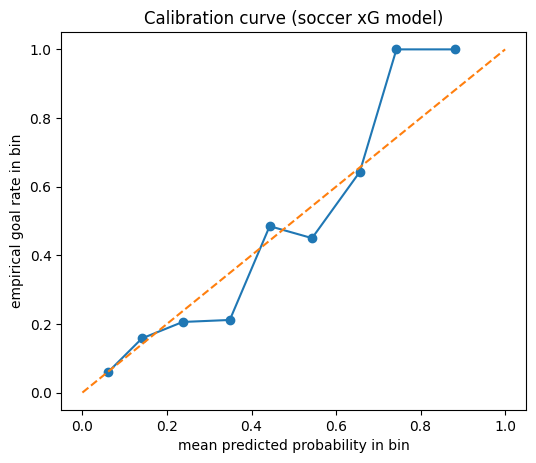


Threshold = 0.05
[[ 494 1697]
 [  20  259]]

Threshold = 0.1
[[1455  736]
 [  94  185]]

Threshold = 0.2
[[1978  213]
 [ 192   87]]


In [65]:
prob_true, prob_pred = calibration_curve(y_test, p_test, n_bins=10, strategy="uniform")

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
ax.plot(prob_pred, prob_true, marker="o")
ax.plot([0, 1], [0, 1], linestyle="--")
ax.set_title("Calibration curve (soccer xG model)")
ax.set_xlabel("mean predicted probability in bin")
ax.set_ylabel("empirical goal rate in bin")
plt.show()

# Confusion matrices at a few thresholds (purely illustrative)
for thr in [0.05, 0.10, 0.20]:
    y_hat = (p_test >= thr).astype(int)
    cm = confusion_matrix(y_test, y_hat)
    print(f"\nThreshold = {thr}")
    print(cm)


### Step 6: visualize the fitted model on the pitch (smooth xG surface)

We'll:
1. create a grid of pitch locations,
2. compute distance + angle for each location,
3. apply the logistic regression model to get $p(\text{goal})$,
4. visualize it as a heatmap.

This is the "continuous" version of the binned conversion heatmap.



/usr/local/anaconda3/envs/covid/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


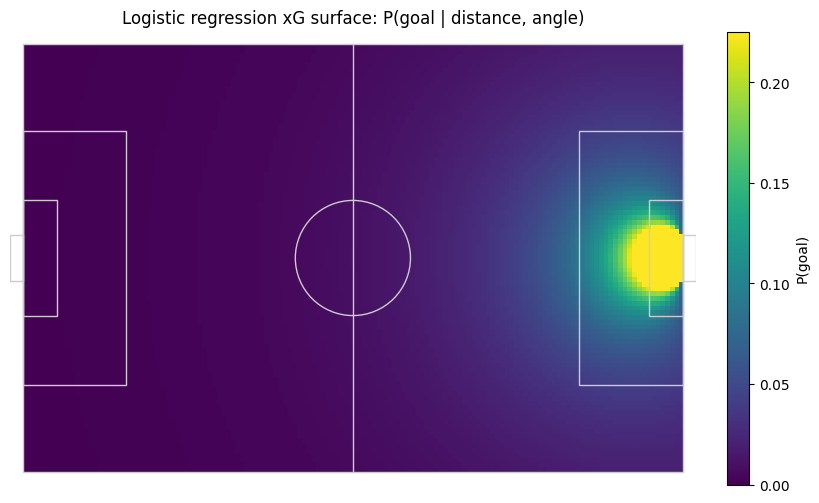

In [66]:
# Grid of pitch locations
nx, ny = 140, 90
grid_x = np.linspace(0, SOCCER_LENGTH_M, nx)
grid_y = np.linspace(0, SOCCER_WIDTH_M, ny)
GX, GY = np.meshgrid(grid_x, grid_y)

d_grid, a_grid = soccer_distance_angle(GX, GY)

X_grid = np.column_stack([d_grid.ravel(), a_grid.ravel()])
p_grid = pipe.predict_proba(X_grid)[:, 1].reshape(ny, nx)

# Mask out the half of the pitch far from goal (optional)
# We'll show full pitch, but note that shots mostly occur in the attacking half.

fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
im = ax.imshow(
    p_grid,
    extent=[0, SOCCER_LENGTH_M, 0, SOCCER_WIDTH_M],
    origin="lower",
    aspect="auto",
    vmin=0, vmax=np.nanpercentile(p_grid, 99)
)
draw_soccer_pitch(ax, color=".8", lw=1.0)
ax.set_title("Logistic regression xG surface: P(goal | distance, angle)")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="P(goal)")
plt.show()


### Step 7: compare our simple model to the provided xG

The dataset includes a provided `xG` column (from a different model).

We can sanity-check whether our probabilities are "in the ballpark" by:
- plotting predicted vs provided xG,
- comparing total xG sums.

Important: differences are expected because real xG models use many more features (shot type, assist type, body part, defensive pressure, etc.).



Total goals: 1115
Total xG (logistic, ours): 1117.81
Total xG (provided column): 1236.54


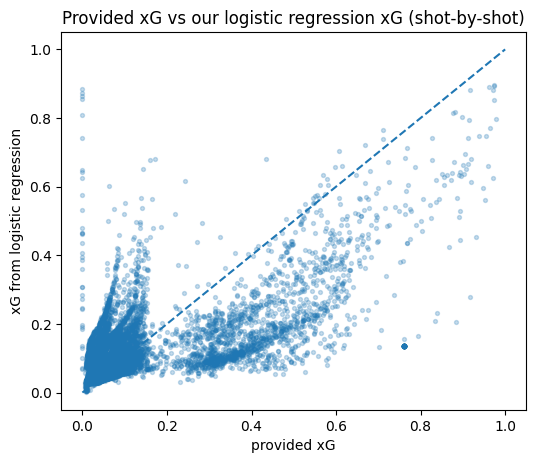

Correlation: 0.644


In [67]:
# Predict for each shot in the dataset
p_all = pipe.predict_proba(soc[["dist","angle"]])[:, 1]
soc["xG_lr"] = p_all

print("Total goals:", int(soc["GOAL"].sum()))
print("Total xG (logistic, ours):", round(float(soc["xG_lr"].sum()), 2))
print("Total xG (provided column):", round(float(soc["xG"].sum()), 2))

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
ax.scatter(soc["xG"], soc["xG_lr"], s=8, alpha=0.25)
ax.plot([0, 1], [0, 1], linestyle="--")
ax.set_title("Provided xG vs our logistic regression xG (shot-by-shot)")
ax.set_xlabel("provided xG")
ax.set_ylabel("xG from logistic regression")
plt.show()

corr = np.corrcoef(soc["xG"], soc["xG_lr"])[0, 1]
print("Correlation:", round(float(corr), 3))


## 2.4 Feature engineering + cross-validation (optional, but recommended)

A geometry-only model is a great starting point, but it ignores context:
- shot type (header vs foot),
- situation (set piece vs open play),
- etc.

Our dataset includes some categorical columns (`shotType`, `situation`, `lastAction`).

We can include them with one-hot encoding and use `LogisticRegressionCV` to tune the regularization strength.

**Important:** avoid "leaky" features (things you wouldn't know at shot time) and be careful with IDs (player names can overfit).



In [68]:
# Build a slightly richer feature set

use_cols_num = ["dist", "angle"]
use_cols_cat = ["shotType", "situation", "lastAction"]

# Some rows might have missing values in assisted/lastAction depending on the data source.
soc_fe = soc.copy()
for c in use_cols_cat:
    soc_fe[c] = soc_fe[c].fillna("Unknown")

X = soc_fe[use_cols_num + use_cols_cat]
y = soc_fe["GOAL"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=7, stratify=y
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("scaler", StandardScaler())]), use_cols_num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), use_cols_cat),
    ]
)

clf_cv = LogisticRegressionCV(
    Cs=8,
    cv=4,
    scoring="neg_log_loss",
    solver="lbfgs",
    max_iter=600,
    n_jobs=None,
)

pipe_cv = Pipeline([
    ("prep", preprocess),
    ("lr", clf_cv),
])

pipe_cv.fit(X_train, y_train)
p_test = pipe_cv.predict_proba(X_test)[:, 1]

print("Richer model (with categorical features)")
print("Test log loss:", round(log_loss(y_test, p_test), 4))
print("Test ROC-AUC:", round(roc_auc_score(y_test, p_test), 4))
print("Test PR-AUC:", round(average_precision_score(y_test, p_test), 4))
print("Test Brier:", round(brier_score_loss(y_test, p_test), 4))


Richer model (with categorical features)
Test log loss: 0.2892
Test ROC-AUC: 0.786
Test PR-AUC: 0.4125
Test Brier: 0.0827


A helpful way to communicate "what improved" is to compare to the geometry-only model.

Remember:
- Lower log loss is better.
- ROC-AUC focuses on ranking, not calibration.
- Brier score focuses on probabilistic accuracy.



# Appendices (deeper dives)

These sections are optional for lecture, but they're here to answer the inevitable:
- "Where did the loss come from?"
- "Why is the gradient that shape?"
- "How do optimizers actually fit this?"

If you're new: skim once, then revisit when you've fit a few models.



## Appendix A — Negative log-likelihood, gradient, and a gradient check

For $p_i = \sigma(\beta_0 + x_i^\top\beta)$, the negative log-likelihood is:

$$
\text{NLL}(\beta_0,\beta) = -\sum_{i=1}^n \left[y_i\log p_i + (1-y_i)\log(1-p_i)\right].
$$

A standard result (worth deriving once) is:

$$
\nabla_\beta \text{NLL} = X^\top(p-y)
$$

and

$$
\frac{\partial}{\partial \beta_0}\text{NLL} = \sum_{i=1}^n (p_i - y_i).
$$

We'll implement NLL + gradient and check it with finite differences.



In [69]:
def nll_and_grad(beta0, beta, X, y, eps=1e-12):
    """Return (nll, grad_beta0, grad_beta) for logistic regression."""
    z = beta0 + X @ beta
    p = sigmoid(z)
    p = np.clip(p, eps, 1-eps)

    nll = -np.sum(y*np.log(p) + (1-y)*np.log(1-p))
    # gradients
    r = (p - y)
    grad_beta0 = np.sum(r)
    grad_beta = X.T @ r
    return nll, grad_beta0, grad_beta

def grad_check(beta0, beta, X, y, h=1e-5):
    """Finite-difference check of gradients."""
    nll0, g0, g = nll_and_grad(beta0, beta, X, y)

    # check beta0
    nll_plus, _, _ = nll_and_grad(beta0+h, beta, X, y)
    nll_minus, _, _ = nll_and_grad(beta0-h, beta, X, y)
    fd_beta0 = (nll_plus - nll_minus) / (2*h)

    # check beta vector
    fd = np.zeros_like(beta)
    for j in range(len(beta)):
        e = np.zeros_like(beta)
        e[j] = h
        nll_plus, _, _ = nll_and_grad(beta0, beta+e, X, y)
        nll_minus, _, _ = nll_and_grad(beta0, beta-e, X, y)
        fd[j] = (nll_plus - nll_minus) / (2*h)

    return fd_beta0, fd, g0, g

# Use the soccer geometry-only features (standardized) on a small subset
X = soc[["dist","angle"]].to_numpy()
y = soc["GOAL"].to_numpy()

# Standardize for stability
mu = X.mean(axis=0)
sd = X.std(axis=0, ddof=0)
sd = np.where(sd == 0, 1.0, sd)
Xz = (X - mu) / sd

idx = RNG.choice(len(y), size=2000, replace=False)
Xz_s = Xz[idx]
y_s = y[idx]

beta0 = 0.1
beta = np.array([0.2, -0.3])

fd_beta0, fd_beta, g0, g = grad_check(beta0, beta, Xz_s, y_s)

print("beta0: finite diff =", fd_beta0, " analytic =", g0)
print("beta : finite diff =", fd_beta, " analytic =", g)
print("max abs diff (beta):", float(np.max(np.abs(fd_beta - g))))


beta0: finite diff = 837.342570025612  analytic = 837.3425700252266
beta : finite diff = [ 397.1014464  -412.43303748]  analytic = [ 397.1014464  -412.43303749]
max abs diff (beta): 1.5612897641403833e-08


## Appendix B — Fitting logistic regression from scratch (gradient descent + Newton/IRLS)

Why do this if scikit-learn exists?
- to demystify what "fitting" means,
- to understand why the loss is convex,
- to see why Newton/IRLS converges in just a few iterations.

We'll fit the geometry-only soccer model on a subset to keep it fast.



In [70]:
# Prepare data
X = soc[["dist","angle"]].to_numpy()
y = soc["GOAL"].to_numpy()

mu = X.mean(axis=0)
sd = X.std(axis=0, ddof=0)
sd = np.where(sd == 0, 1.0, sd)
Xz = (X - mu) / sd

idx = RNG.choice(len(y), size=4000, replace=False)
Xz = Xz[idx]
y = y[idx]

# ---------- Gradient descent ----------
beta0 = 0.0
beta = np.zeros(Xz.shape[1])

lr = 0.05
for t in range(600):
    nll, g0, g = nll_and_grad(beta0, beta, Xz, y)
    beta0 -= lr * g0 / len(y)
    beta  -= lr * g / len(y)
    if t in [0, 1, 2, 5, 10, 50, 200, 599]:
        print(f"iter {t:>3}  NLL/n = {nll/len(y):.4f}")

p_gd = sigmoid(beta0 + Xz @ beta)
print("GD subset log loss:", round(log_loss(y, p_gd), 4))

# ---------- Newton / IRLS ----------
def newton_irls(X, y, n_steps=8, damp=1e-6):
    beta0 = 0.0
    beta = np.zeros(X.shape[1])

    for k in range(n_steps):
        z = beta0 + X @ beta
        p = sigmoid(z)
        w = p * (1 - p)  # weights
        # Avoid zero weights
        w = np.maximum(w, 1e-9)

        # Working response
        z_work = z + (y - p) / w

        # Weighted least squares solve for beta0,beta
        # Add intercept column
        X1 = np.column_stack([np.ones(len(y)), X])
        W = np.diag(w)

        A = X1.T @ W @ X1 + damp*np.eye(X1.shape[1])
        b = X1.T @ W @ z_work
        params = np.linalg.solve(A, b)

        beta0 = params[0]
        beta = params[1:]
        nll, _, _ = nll_and_grad(beta0, beta, X, y)
        print(f"Newton step {k:>2}  NLL/n = {nll/len(y):.4f}")
    return beta0, beta

beta0_n, beta_n = newton_irls(Xz, y, n_steps=7)
p_n = sigmoid(beta0_n + Xz @ beta_n)
print("Newton subset log loss:", round(log_loss(y, p_n), 4))


iter   0  NLL/n = 0.6931
iter   1  NLL/n = 0.6849
iter   2  NLL/n = 0.6770
iter   5  NLL/n = 0.6542
iter  10  NLL/n = 0.6202
iter  50  NLL/n = 0.4593
iter 200  NLL/n = 0.3357
iter 599  NLL/n = 0.3152
GD subset log loss: 0.3152
Newton step  0  NLL/n = 0.3426
Newton step  1  NLL/n = 0.3167
Newton step  2  NLL/n = 0.3141
Newton step  3  NLL/n = 0.3140
Newton step  4  NLL/n = 0.3140
Newton step  5  NLL/n = 0.3140
Newton step  6  NLL/n = 0.3140
Newton subset log loss: 0.314


# Wrap-up

What we did:
- Used expectation + binning to build empirical heatmaps (density, conversion, expected points).
- Explained logistic regression as a model for log-odds and probabilities.
- Fit a geometry-only xG model (distance + angle) and visualized it as a smooth surface.
- (Optional) Included richer features and cross-validation.
- (Appendices) Derived and checked gradients, and implemented Newton/IRLS.

Where this could go next:
- hierarchical / mixed-effects logistic regression (player effects),
- spatial kernels / Gaussian processes for smoothness,
- tree-based models (XGBoost) for nonlinear interactions,
- adding tracking/freeze-frame data (defender pressure).

__________
## Next time...
Regression Pt. 3.5 — Survival Analysis `class_08_regression_04_survival_logistic.ipynb`

_______

## References and further resources:

### Logistic regression (concept + math + history)
- J.S. Cramer, *The Origins of Logistic Regression* (Tinbergen Institute Discussion Paper, 2002): https://www.econstor.eu/bitstream/10419/86100/1/02119.pdf  
- Pierre-François Verhulst (historical logistic growth), excerpted/translated in N. Bacaër, *Verhulst and the logistic equation (1838)* (PDF): https://webpages.ciencias.ulisboa.pt/~mcgomes/aulas/dinpop/Mod13/Verhulst.pdf  
- Cramer (2003), *The origins and development of the logit model* (includes Berkson 1944 reference): https://drupal-s3fs-prod.s3.eu-west-1.amazonaws.com/resources/academic/2013/6690/1022/1208_default.pdf  
- *An Introduction to Statistical Learning* (ISLR, free PDF): https://www.stat.berkeley.edu/~rabbee/s154/ISLR_First_Printing.pdf  
- Cosma Shalizi, *Logistic Regression* lecture notes (Newton/IRLS): https://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch12.pdf  

### Practical implementations (Python)
- scikit-learn `LogisticRegression` docs (solvers, regularization): https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html  
- scikit-learn `LogisticRegressionCV` docs (cross-validated regularization): https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html  

### Expected goals (xG) tutorials and context
- Soccermatics: *Fitting the xG model* (step-by-step, angle + distance): https://soccermatics.readthedocs.io/en/latest/gallery/lesson2/plot_xGModelFit.html  
- Soccermatics: *Geometry of Shooting* (deriving shot angle): https://soccermatics.readthedocs.io/en/latest/lesson2/GeometryOfShooting.html  
- StatsBomb glossary: Expected Goals (what modern xG models consider): https://support.hudl.com/s/article/expected-goals?topic=Statsbomb_Global_Football_Data_Glossary  
